# Process the Environmental, Social, and Governance (ESG) information with Probabilistic Machine Learning model for Sustainability Investment

> Nowadays, the Web is a common medium for corporations to effectively disseminate and demonstrate their efforts to incorporate sustainability practices into their business processes.  This led to the idea of using the Web as a source of data to measure how companies are progressing towards meeting the new sustainability requirements recently stipulated by the United Nations. From a initial sample of sustainability-related reports were identified and collected.
- Environmental, social, and governance (ESG) criteria are a set of standards for a company’s operations that socially conscious investors use to screen potential investments.
- Environmental criteria consider how a company performs as a steward of nature and environmentally conscious.
- Social criteria examine how it manages relationships with employees, suppliers, customers, and the communities where it operates.
- Governance deals with a company’s leadership, executive pay, audits, internal controls, and shareholder rights.

> Topic models represent a family of machine learning algorithms that extract topics from raw texts.  A topic is intended here as a list of words that occur in statistically meaningful ways.  Topic modelling algorithms do not require any prior annotations or labelling of the documents.  Instead, the topics emerge from the analysis of the original texts.  Latent Dirichlet Allocation (LDA) is a special type of unsupervised topic modelling.  Given a collection of documents, it assigns to each topic to a distribution over words and to each document to a distribution over topics.

> Here we use LDA to identify topics on the text extracted from pdf documents or raw texts from NIPS papers.  Topics can allow us to understand what areas of sustainability each document covers, such as environment, supporting charities, employees well-being, etc., and in what proportion.  Some of the covered areas are : 
- Explore Latent Dirichlet Allocation on ESG pdf documents and/or NIPS papers
- Topic predictions for unseen documents
- Using K-Means clustering algorithm for ESG categorisation
- Using Max matching word ratio to identify the ESG category with reference to the input ESG dictionary from domain expert
- Multi-class predictions for ESG category

> References :<br>
>[1] Latent Dirichlet Allocation, by David M. Blei, Andrew Y. Ng and Michael I. Jordan, 2003<br>
>[2] LDAvis: A method for visualizing and interpreting topics, by Carson Sievert and Kenneth E. Shirley, 2014.<br>

# Explore Latent Dirichlet Allocation (LDA) with NIPS Papers or ESG papers
- adapted for Colab

In [1]:
# Importing modules
import pandas as pd
import os
from os import listdir
import pprint
import pickle
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Load the regular expression library
import re

# Import the wordcloud library
# Requirements : wordcloud==1.8.1 also works for 1.5.0
!pip install wordcloud==1.8.1
from wordcloud import WordCloud

# Package contains interfaces and functionality to compute pair-wise document similarities within a corpus of documents
import gensim
from gensim.utils import simple_preprocess

# Natural Language Toolkit
import nltk
nltk.download('stopwords') # if Package stopwords do not exist
from nltk.corpus import stopwords

# Use pyLDAvis 3.2.2 to avoid "No module found" in virtual environment
# !pip uninstall -y pyLDAvis
!pip install pyldavis==3.2.2

# For LDA Visualisation
import pyLDAvis

import pyLDAvis.gensim

def save_csv_file(dataframe, filename):
    # Save words dataframe in CSV file with provided filename
    dataframe.to_csv(filename, index=False)

# Intersection method to check for matching words
def intersection(list1, list2): 
    return list(set(list1) & set(list2))

     |████████████████████████████████| 366 kB 8.1 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.7 MB 7.1 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135617 sha256=781c07cb4fd71387ce7347960c69fa45264f223feb32947a8e87c5ea85b6e43d
  Stored in directory: /root/.cache/pip/wheels/f8/b1/9b/560ac1931796b7303f7b517b949d2d31a4fbc512aad3b9f284
Successfully built pyldavis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# Use for pdf text extraction
!pip install pdfplumber
# Need to restart runtime after gensim installation

In [ ]:
# Solve the KeyError: dtype('float32')
# !pip install gensim --upgrade
!pip install gensim==4.0.1
# Need to restart runtime

In [ ]:
# Confirm on the correct versions for the Colab notebook
# pyLDAvis                      3.2.2
# wordcloud                     1.8.1
# Pillow                        9.1.0
# gensim                        4.0.1
!pip list|grep pyLDAvis
!pip list|grep wordcloud
!pip list|grep Pillow  # should be 9.1.0 for PIL to work without Resampling error
!pip list|grep gensim  # should be 3.8.3; kaggle is with 4.0.1
# pyLDAvis.gensim.prepare

pyLDAvis                      3.2.2
wordcloud                     1.8.1
Pillow                        9.1.0
gensim                        4.0.1


In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 4.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# Resolve the PIL no "Resampling" attribute error for version "8.2.0"
# After restart runtime otherwise version is 7.1.2 with error "'PIL.TiffTags' has no attribute 'IFD'"
# !pip uninstall -y Pillow
# !pip install Pillow==8.2.0 # Pillow==5.3.0
# Just restart the pdfplumber runtime without installing version Pillow==8.2.0
# Needs version Pillow==9.1.0
import PIL

# print(PIL.PILLOW_VERSION) on Kaggle
print(PIL.__version__) # Verify 9.1.0

9.1.0


# README
- Alternatives :
> 1. Using pdftotext instead of pdfplumber, it was observed giving double the amount of characters
> 2. Use only 104 sample files (2 incomplete or damaged files in ESG_DF/ESG_D3)
> 3. No true improvements in Coherence Score; approx. 0.42 with 6 topics

# Section A : Extract texts from PDF files to create document repository

- Replace 'doc_text' column name with 'paper_text'
- Can be used to extract pdf files for LDA model training instead of model inference
- For unseen data then you have to copy cell to create dataframe before using it later in inference

In [ ]:
# Mount drive from colab to Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !ls -tlag /content/gdrive/MyDrive/Colab\ Notebooks/project/LDA  # ESG_PDF/ESG_D3/Damage/

In [ ]:
# %%time
# # https://github.com/jsvine/pdfplumber
# import pdfplumber

# ###
# pdfToText = ''
# pdf_filename = '/kaggle/input/nips-papers/LDAvis.pdf'
# # 52 files from ESG repository
# PDF_DIR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/project/LDA/ESG_PDF/'
# pdf_text_df = pd.DataFrame(columns=['pdf_name', 'total_pages', 'paper_text', 'chars'])  # doc_text

# pdf_text_dict = {}

# filenames = [fname for fname in listdir(PDF_DIR_PATH) if os.path.isfile(PDF_DIR_PATH+fname)]
# pdf_filenames = filter(lambda fname: fname.endswith(('.pdf','.PDF')), filenames)
# list_pdf_filenames = list(pdf_filenames)

# noOfDocs = 0
# for pdf_filename in list_pdf_filenames:
#     with pdfplumber.open(PDF_DIR_PATH + pdf_filename) as pdf:
#         noOfDocs += 1
#         # Reset the extracted text
#         pdfToText = ''
#         for page in pdf.pages:
#             pdfToText += page.extract_text()

#         # Extract single page
#         # first_page = pdf.pages[0]
#         # print(first_page.extract_text())
#         # type(pdf), type(first_page)

#         # Store extracted texts for each pdf file
#         pdf_text_dict['pdf_name'] = pdf_filename
#         pdf_text_dict['total_pages'] = len(pdf.pages)
#         pdf_text_dict['paper_text'] = pdfToText  # doc_text
#         pdf_text_dict['chars'] = len(pdfToText)

#         pdf_text_df = pdf_text_df.append(pdf_text_dict, ignore_index=True, sort=False)
#         # Some texts are joint into a word and column texts need to be manipulated
#         print("Pdf_{} : Texts can be extracted from {} pages in \'{}\'".format(noOfDocs, len(pdf.pages), pdf_filename))
#         print("-" * 100)

# pdf_text_df

In [ ]:
# !ls -tl /content/gdrive/MyDrive/Colab\ Notebooks/project/LDA/ESG_PDF/ESG_D3/Damage/

## 1. PDF text extraction using pdfplumber library

In [ ]:
import pdfplumber

# Damage file spotted by pdftotext but somehow some text can be extracted by pdfplumber
pdf_filename = '/content/gdrive/MyDrive/Colab Notebooks/project/LDA/ESG_PDF/ESG_D3/Damage/global-impact-2020.pdf'
pdfToText = ''

with pdfplumber.open(pdf_filename) as pdf:
    for page in pdf.pages:
        pdfToText += page.extract_text()

pdfToText

' \n2020\nGLOBAL IMPACT REPORT'

In [ ]:
# https://github.com/jsvine/pdfplumber
import pdfplumber

def extractTextfromPDFToDF(docs_path):
    pdfToText = ''
    pdf_text_df = pd.DataFrame(columns=['pdf_name', 'total_pages', 'paper_text', 'chars'])  # doc_text

    pdf_text_dict = {}

    filenames = [fname for fname in listdir(docs_path) if os.path.isfile(docs_path+fname)]
    pdf_filenames = filter(lambda fname: fname.endswith(('.pdf','.PDF')), filenames)
    list_pdf_filenames = list(pdf_filenames)

    noOfDocs = 0
    for pdf_filename in list_pdf_filenames:
        print("Processing \'{}\'...".format(pdf_filename))

        with pdfplumber.open(docs_path + pdf_filename) as pdf:
            noOfDocs += 1
            # Reset the extracted text
            pdfToText = ''
            for page in pdf.pages:
                pdfToText += page.extract_text()

            # Extract single page
            # first_page = pdf.pages[0]
            # print(first_page.extract_text())
            # type(pdf), type(first_page)

            # Store extracted texts for each pdf file
            pdf_text_dict['pdf_name'] = pdf_filename
            pdf_text_dict['total_pages'] = len(pdf.pages)
            pdf_text_dict['paper_text'] = pdfToText  # doc_text
            pdf_text_dict['chars'] = len(pdfToText)

            pdf_text_df = pdf_text_df.append(pdf_text_dict, ignore_index=True, sort=False)
            # Some texts are joint into a word and column texts need to be manipulated
            print("Pdf_{} : Texts can be extracted from {} pages in \'{}\'".format(noOfDocs, len(pdf.pages), pdf_filename))
            print("-" * 100)

    return pdf_text_df

In [ ]:
%%time
# 52 files from ESG repository; Wall time: 22min 42s
# 52 + 26 + 28 = 105 files from ESG repository; Wall time: 38min 55s

PDF_DIR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/project/LDA/ESG_PDF/'
train_text_df = extractTextfromPDFToDF(PDF_DIR_PATH)

# Save train_text_df to CSV file
save_csv_file(train_text_df, 'ESG_papers.csv')  # pdf_text_df

In [ ]:
train_text_df

In [ ]:
%%time
# pdf_filename = '/kaggle/input/nips-papers/LDAvis.pdf'
# Extract text to be used for testing with unseen document
PDF_DIR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/project/LDA/'  # '/kaggle/input/nips-papers/' path in Kaggle
test_text_df = extractTextfromPDFToDF(PDF_DIR_PATH)

Processing 'HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf'...
Pdf_1 : Texts can be extracted from 8 pages in 'HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf'
----------------------------------------------------------------------------------------------------
Processing 'LDAvis.pdf'...
Pdf_2 : Texts can be extracted from 8 pages in 'LDAvis.pdf'
----------------------------------------------------------------------------------------------------
Processing 'energies-15-00045.pdf'...
Pdf_3 : Texts can be extracted from 20 pages in 'energies-15-00045.pdf'
----------------------------------------------------------------------------------------------------
Processing 'esg-issues-in-investing-a-guide-for-investment-professionals.pdf'...
Pdf_4 : Texts can be extracted from 52 pages in 'esg-issues-in-investing-a-guide-for-investment-professionals.pdf'
-------------------------------------------------------------------------------------------

In [ ]:
test_text_df

,pdf_name,total_pages,paper_text,chars
0,HogRider_Champion Agent of Microsoft Malmo Col...,8,HogRider: Champion Agent of Microsoft Malmo Co...,40377
1,LDAvis.pdf,8,LDAvis: A method for visualizing and interpret...,31350
2,energies-15-00045.pdf,20,energies\nArticle\nRenewable Energy Sources as...,83759
3,esg-issues-in-investing-a-guide-for-investment...,52,"ENVIRONMENTAL, \nSOCIAL, AND \nGOVERNANCE \nTH...",96337
4,ey-global-institutional-investor-survey-2020.pdf,36,How will ESG \nperformance shape \nyour future...,82028


In [ ]:
# Save test_text_df to CSV file
save_csv_file(test_text_df, 'ESG_test_papers.csv')

## 1.1 PDF text extraction alternative using pdftotext library

#### Comparisons between Text Extraction libraries
- Extraction via pdfplumber has lesser chars compared to pdfToText
- pdf_name	total_pages	paper_text	chars

> 0 20210325_PG_Corporate_Sustainability_Report_20...	45	Kirsta Anderson Global Head Human Resources | ...	253977</br>
> 1	2021-ESG-Report.pdf	118	This document contains both information and na...	468981</br>
> 2	2021_esgReport_eng_highlight.pdf	100	SHINHAN FINANCIAL GROUP\n2021 ESG HIGHLIGHT fo...	223339</br>
> 3	066-00338-01-2020-esg-report.pdf	205	I N t ersections\n2020 | Environmental, Soci...	457959</br>
> 4	2022-Corporate-Responsibility-Report.pdf	98	Delivering on our Purpose\n2022 CORPORATE RESP...	220250</br>


In [ ]:
# Extraction from pdftotext has not been uploaded
# !sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
# !pip install pdftotext

In [ ]:
# import pdftotext

# def extractTextfromPDFToDF(docs_path):
#     pdfToText = ''
#     pdf_text_df = pd.DataFrame(columns=['pdf_name', 'total_pages', 'paper_text', 'chars'])  # doc_text

#     pdf_text_dict = {}

#     filenames = [fname for fname in listdir(docs_path) if os.path.isfile(docs_path+fname)]
#     pdf_filenames = filter(lambda fname: fname.endswith(('.pdf','.PDF')), filenames)
#     list_pdf_filenames = list(pdf_filenames)

#     noOfDocs = 0
#     for pdf_filename in list_pdf_filenames:
#         # Reset the no. of characters in extracted text
#         noOfCharsInDoc = 0
#         print("Processing \'{}\'...".format(pdf_filename))

#         with open(docs_path + pdf_filename, "rb") as pdf_file:
#             noOfDocs += 1
            
#             # Extracted text
#             pdf = pdftotext.PDF(pdf_file)
            
#             for page in pdf:
#                 noOfCharsInDoc += len(page)

#             # Store extracted texts for each pdf file
#             pdf_text_dict['pdf_name'] = pdf_filename
#             pdf_text_dict['total_pages'] = len(pdf)
#             pdf_text_dict['paper_text'] = "".join(pdf)
#             pdf_text_dict['chars'] = noOfCharsInDoc

#             pdf_text_df = pdf_text_df.append(pdf_text_dict, ignore_index=True, sort=False)
#             # Some texts are joint into a word and column texts need to be manipulated
#             print("Pdf_{} : Texts can be extracted from {} pages in \'{}\'".format(noOfDocs, len(pdf), pdf_filename))
#             print("-" * 100)

#     return pdf_text_df

# PDF_DIR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/project/LDA/ESG_PDF/'
# train_text_df = extractTextfromPDFToDF(PDF_DIR_PATH)

# Save train_text_df to CSV file
# save_csv_file(train_text_df, 'ESG_papers.csv')  # pdf_text_df

# Section B : Data Mining

## 1. Load Data

- Need to replace with the correct path if you still like to train with the 'papers.csv' otherwise skipped to next cell to run own ESG data


In [ ]:
# Load data into papers from ESG data
# '/content/gdrive/MyDrive/Colab Notebooks/project/LDA/papers.csv'  # ESG_papers
papers = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/project/LDA/papers.csv')  # /kaggle/input/nips-papers/papers.csv

# papers.shape : (6560, 7) for NIPS Paper
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [ ]:
# Should be (104, 4) for pdfToText with ESG documents
papers.shape

(6560, 7)

## 2. Data Cleaning for NLP

In [ ]:
def drop_dataframe_cols(papers):
    papers_col_names = list(papers.columns)
    NIPS_paper_cols_drop = ['id', 'event_type', 'abstract']
    num_matched_col_names = len(NIPS_paper_cols_drop)

    # Keep only the required columns and obtain first 500 samples [:500]
    if len(intersection(NIPS_paper_cols_drop, papers_col_names)) == num_matched_col_names:
        # For NIPS papers only
        print("Drop columns from papers :", NIPS_paper_cols_drop)
        papers_text_df = papers.drop(columns=NIPS_paper_cols_drop, axis=1)
    else:
        # text extracted from ESG papers
        papers_text_df = papers
        print("Total processed {} pages in {} pdf documents".format(papers['total_pages'].sum(), papers.shape[0]))

    return papers_text_df


# Or get random samples with papers.sample(samples)
samples = papers.shape[0]
print("No. of samples from papers :", samples)
papers_text_df = drop_dataframe_cols(papers)

papers_text_df.head()

No. of samples from papers : 6560
Drop columns from papers : ['id', 'event_type', 'abstract']


,year,title,pdf_name,paper_text
0,1987,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,10-a-mean-field-theory-of-layer-iv-of-visual-c...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,100-storing-covariance-by-the-associative-long...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,1000-bayesian-query-construction-for-neural-ne...,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",1001-neural-network-ensembles-cross-validation...,"Neural Network Ensembles, Cross\nValidation, a..."


### Remove punctuations and lower casing
* Perform a simple preprocessing on the content of "paper_text" column to make them more amenable for analysis. Use a regular expression to remove any punctuations and lowercase text.  We might also want to remove plurality.

In [ ]:
# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\\.!?]', '', x)) # replace \ with \\

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

# papers['paper_text_processed'].iloc[0]

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

## 3. Exploratory Data Analysis (EDA)

* Using the wordcloud package to have a visual representation of most common words before processing.
* Preprocessed the data words (remove stop words, bi-gram, lemmatization)
* Obtain a visual representation of the preprocessed words to be used for LDA

In [ ]:
# Exracting words from sentences and preprocessing
def generate_save_wordcloud(listOfWords:list, filename):
    # Join the different processed titles together.
    long_string = ','.join(listOfWords)

    # Added to silent DeprecationWarning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        
        # Create a WordCloud object
        wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

        # Generate a word cloud
        wordcloud.generate(long_string)

        # Visualize the word cloud
        wordcloud.to_image()

    # Ref : https://www.datacamp.com/community/tutorials/wordcloud-python
    # Save in default kaggle directory, "/kaggle/working/"
    wordcloud.to_file(filename)

In [ ]:
%%time
filename = 'wordcloud_' + str(samples) + '_samples.png'
listOfWords = list(papers['paper_text_processed'].values)

generate_save_wordcloud(listOfWords, filename)

CPU times: user 1min 49s, sys: 4.85 s, total: 1min 54s
Wall time: 2min 5s


## 4. Prepare text for Latent Dirichlet Allocation (LDA)

* Transform the textual data in a format that will serve as an input for training a LDA model.
> * Tokenizing the text and removing stopwords
> * Convert the tokenized object into a corpus and dictionary

In [ ]:
# Added to silent DeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import spacy
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

## 4.1 Phrase Modeling: Bigram and Trigram Models
* Bigrams and Trigrams are 2 and 3 words frequently occurring together in the document.
* Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more.  The two important arguments to Phrases model are min_count and threshold.

In [ ]:
stop_words = stopwords.words('english')

# Customise to included other stop words
stop_words.extend(['from', 'subject', 're', 'edu', 'use',
                   'hisashi', 'suzuki', 'suguru', 'arimoto', 'university', # Remove some author names from NIPS
                   'kirsta', 'anderson', 'aancdti', 'yy', 'y', 'dei', 'ungc', 'fy']) # Remove some names from ESG papers

# Exracting words from sentences and preprocessing
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True will remove punctuations
        # yield returns a generator that produces the words for each paper_text
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    # Build the bigram models; higher threshold gives fewer phrases.
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # data_words

    # Faster way to get a sentence clubbed as a bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    # bigram.vocab.keys() # [b'resources']
    # bigram_mod.phrasegrams

    # return bigram in list
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    # Build the bigram and trigram models; higher threshold gives fewer phrases.
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)  # data_words

    # Faster way to get a sentence clubbed as a trigram
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags):  # allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    # Nouns are the most useful in understanding the context of a conversation
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Peform n-grams and lemmatization
def get_data(data_words):
    """
    Get Bigram Model, lemmatization mapping
    """
    # Remove stop words from data_words
    data_words_nostops = remove_stopwords(data_words)
    print("After removing stop words :\n", data_words_nostops[:1][0][:30])
    print()

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    print("After making bigrams :\n", data_words_bigrams[:1][0][:30])
    print()
    
    # Do lemmatization keeping only noun, adj, vb, adv
    data_words_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])  # understanding the context without 'ADJ', 'VERB', 'ADV'
    print("After lemmatization :\n", data_words_lemmatized[:1][0][:30])

    return data_words_bigrams, data_words_lemmatized

In [ ]:
%%time
# Store all paper_text from samples into list
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
print("Before removing stop words for {} documents with sample :\n{}".format(len(data_words), data_words[:1][0][:30]))

In [ ]:
%%time
# Added to silent DeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    train_bigrams, train_lemmatized = get_data(data_words)

# train_bigrams[0], train_lemmatized[0]

In [ ]:
print("\nDimension of train_lemmatized : ({}, {}, {})".format(len(train_lemmatized),
                                                              len(train_lemmatized[0]),
                                                              len(train_lemmatized[0][0])))

In [ ]:
# Get few samples of lemmatized words
train_lemmatized[0][:5]

In [ ]:
# Flattened for wordcloud
flat_list = []
for sublist in train_lemmatized:
    for item in sublist:
        flat_list.append(item)

flat_list[:5]

In [ ]:
# len(flat_list) gives 845324 with 'NOUN' allowed tag
# len(flat_list) gives 822100 with 'NOUN' allowed tag and removing the stop words when making bigrams; save memory space
len(flat_list)

In [ ]:
%%time
filename = 'wordcloud_' + str(samples) + '_samples_processed.png'
listOfWords = flat_list

generate_save_wordcloud(listOfWords, filename)

## 4.2 Data transformation: Corpus and Dictionary
* The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

In [ ]:
import gensim.corpora as corpora

def get_corpus(data_lemmatized):
    """
    Get id2word, corpus mapping
    """
    # Ref : https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.doc2bow.html
    # Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
    # Each word is assumed to be a tokenized and normalized string.
    # No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized) # data_words_nostops, data_words
    print("Created dictionary of size {} with sample word : \'{}\'".format(len(id2word), id2word[0]))
    
    # Filter out tokens that appear in < no_below documents or more than no_above documents (fraction of total corpus size)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    # Calling this method will remove the gaps and make the ids more compact (eg. after some tokens have been removed via filter_extremes)
    id2word.compactify()

    # Create Corpus
    texts =  data_lemmatized # data_words_nostops

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Show the id with the respective frequency
    print("Corpus of {} documents with sample :\n{}".format(len(data_words), corpus[:1][0][:30]))

    return id2word, corpus

In [ ]:
%%time
train_id2word, train_corpus = get_corpus(train_lemmatized)
# Created dictionary of size 14112 with sample word : 'ability' for ESG (NOUN and others, complete data words for bigrams) 

In [ ]:
# Get a sample of train corpus
train_corpus[:1][0][:5]

In [ ]:
#  list of (token_id, token_count) 2-tuples
print(train_corpus[:1][0][:30][:])

print("\nDimension of corpus : ({}, {}, {})".format(len(train_corpus), len(train_corpus[0]),
                                                    len(train_corpus[0][0])))  # for more than 2 documents

In [ ]:
# https://radimrehurek.com/gensim/corpora/dictionary.html
# Vocabulary size, word<->id mappings
print("Size of dictionary, \'train_id2word\' : {} words with {} processed words".format(len(train_id2word),
                                                                                        train_id2word.num_pos))

In [ ]:
# token -> token_id
# train_id2word.token2id

# 'token_id' is the dictionary key
show_dict_items = {token_id: train_id2word[token_id] for token_id in list(train_id2word)[:10]}
show_dict_items

In [ ]:
# Get a sample of dictionary word
train_id2word[316]

In [ ]:
# Save Dictionary to a text file
train_id2word.save_as_text('doc_dictionary.csv')

In [ ]:
type(train_id2word)

* HDP Model - infers the number of topics from the data
1. > Gensim provides a Hierarchical Dirichlet Process (HDP) class which is similar to LDA, except it learns the correct number of topics from the data via Online Variational Bayes Inference.  Thus, we do not need to provide a fixed number of topics (https://radimrehurek.com/gensim/models/hdpmodel.html).
2. > Running HDP on the 100 (or 6,560) papers few times and we use the number of topics it was learning; which is always 20 topics for this dataset.  It does not give a good coherence score compared to manual hyperparameter tuning with number of topics.

In [ ]:
%%time
from gensim.models import HdpModel
hdp = HdpModel(train_corpus, train_id2word, chunksize=10000)

In [ ]:
print("No. of HDP topics :", len(hdp.print_topics()))
hdp.print_topics(num_topics=len(hdp.print_topics()))

## 5. Latent Dirichlet Allocation (LDA) model training

* Start with default parameters except for specifying the number of topics.
> Eg. Build a model with 10 topics whereby each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [ ]:
%%time
# number of topics that need to experiment with based on the documents
num_topics = len(hdp.print_topics()) # 11-13 topics for NIPS Papers without HDP
print("num_topics :", num_topics)

# Added to silent DeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=train_corpus,
                                          id2word=train_id2word,
                                          num_topics=num_topics)

# Print the Keyword in the number of topics
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(lda_model.print_topics())

doc_lda = lda_model[train_corpus]

doc_lda[0]

In [ ]:
# Show topics for each pdf document
for i in range(5):
    print(doc_lda[i][:][:])
    print()

In [ ]:
%%time
from gensim.models import CoherenceModel

# Compute Coherence Score for LDA with default values and HPA suggested num_topics = 20
#  'c_v topic coherence' measures how often the topic words appear together in the corpus
coherence_model_lda = CoherenceModel(model=lda_model, texts=train_lemmatized,
                                     dictionary=train_id2word, coherence='c_v')

# Value changed with every execution
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of LDA with default values :', coherence_lda)

# Might want to explore C_p, C_npmi or C_uci for evaluating topics.
# https://github.com/dice-group/Palmetto/issues/12

In [ ]:
lda_model.save('lda_basic_train.model')

* Save data for future explorations

In [ ]:
with open('train_bigrams.pkl', 'wb') as output_fname:
    pickle.dump(train_bigrams, output_fname)
with open('train_lemmatized.pkl', 'wb') as output_fname:
    pickle.dump(train_lemmatized, output_fname)
with open('train_id2word.pkl', 'wb') as output_fname:
    pickle.dump(train_id2word, output_fname)
with open('train_corpus.pkl', 'wb') as output_fname:
    pickle.dump(train_corpus, output_fname)

In [ ]:
with open('train_bigrams.pkl', 'rb') as input_fname:
    train_bigrams = pickle.load(input_fname)
with open('train_lemmatized.pkl', 'rb') as input_fname:
    train_lemmatized = pickle.load(input_fname)
with open('train_id2word.pkl', 'rb') as input_fname:
    train_id2word = pickle.load(input_fname)
with open('train_corpus.pkl', 'rb') as input_fname:
    train_corpus = pickle.load(input_fname)

## 5.1 Latent Dirichlet Allocation (LDA) Base model

In addition to the corpus and dictionary, you need to provide the number of topics which can also be explored with Hierarchical Dirichlet Process (HDP).  The alpha and eta are hyperparameters that affect sparsity of the topics.  With reference to the Gensim docs, both defaults to 1.0/num_topics prior (default values are used for the base model) :

1. **chunksize** controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
2. **passes** controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.


In [ ]:
%%time
batch = 100
epochs = 10
iteration_coherence_scores = {}
max_coherence_score = 0.39  # 0.5 amd 0.4 for NIPS papers and ESG papers respectively
optimal_num_topics = 20
min_range = 6
max_range = 16

# 9 samples from range(7, 16) for NIPS
# range(5, 16) for ESG (NOUN and others, complete data words for bigrams)
for num_topics in range(min_range, max_range):
    print("num_topics :", num_topics)

    # Added to silent DeprecationWarning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        # Build LDA baseline model with parameters which produces better words for describing the document
        # With 'random_state', results can still vary due to non-determinism in OS scheduling of the worker processes
        lda_baselined_model = gensim.models.LdaMulticore(corpus=train_corpus,
                                                        id2word=train_id2word,
                                                        num_topics=num_topics,
                                                        random_state=100,       # attempt reproducibility
                                                        chunksize=batch,
                                                        passes=epochs, 
                                                        per_word_topics=True)

        # Compute Coherence Score with chunksize and passes values
        coherence_model_lda = CoherenceModel(model=lda_baselined_model,texts=train_lemmatized,
                                            dictionary=train_id2word, coherence='c_v')

        coherence_lda = coherence_model_lda.get_coherence()
        print('For num_topics = {}, Coherence Score = {}'.format(num_topics, coherence_lda))
            
        iteration_coherence_scores[num_topics] = round(coherence_lda, 3)

        if coherence_lda > max_coherence_score:
            max_coherence_score = coherence_lda
            optimal_num_topics = num_topics
            print("Current max coherence score :", max_coherence_score)
        
        # Save model with k topics
        # Need to download ".expElogbeta.npy", ".id2word" and ".state" for saving
        # For NIPS papers : num_topics >= 11 and num_topics <=13
        # num_topics >= 17 and num_topics <= 19 for NOUN words only on ESG papers
        if (num_topics >= 7 and num_topics <= 13):   # ESG 7-9 (NOUN and others, complete data words for bigrams)
            print("Saving LDA model with {} topics".format(num_topics))
            lda_model_filename = 'lda_baselined_' + str(num_topics) + '_topics.model'
            lda_baselined_model.save(lda_model_filename)
        
    print("-"*70)

print()
print("Optimal number of topics for LDA model :", optimal_num_topics)
iteration_coherence_scores

In [ ]:
# Different in each run even with 'random_state' because of the probabilistic nature of LDA
# Compare to Coherence Score of LDA with default values and num_topics = 20 : 0.2126938524226747
# For num_topics = 15, Coherence Score = 0.5805951970705756
# For num_topics = 14, Coherence Score = 0.5886360771545663
# For num_topics = 13, Coherence Score = 0.5989756758451199
# For num_topics = 12, Coherence Score = 0.5915691739022426
# For num_topics = 11, Coherence Score = 0.6015678202499711 <---
# For num_topics = 10, Coherence Score = 0.5790276563252841
# For num_topics = 9, Coherence Score = 0.5594170876634762
# For num_topics = 8, Coherence Score = 0.5773567490827142
# For num_topics = 7, Coherence Score = 0.5710087036365089

# iteration_coherence_scores = {7 : 0.571, 8 : 0.577, 9 : 0.560,
#                               10 : 0.579, 11 : 0.602, 12 : 0.592,
#                               13 : 0.599, 14 : 0.589, 15 : 0.581}

iteration_coherence_scores

In [ ]:
def plot_coherence_vs_topics(iteration_coherence_scores, save_file_name=None):
    """
    params:
    - iteration_scores: {
        num_topics : Coherence Score for number of topics
    }
    - save_file_name (str): file name with directory path to save plot; default is None (which is not saved)
    """
    plt.figure(figsize=(16, 8))
    padding = 0.01 # 0.005
    
    # key-value pair
    num_topics_min_coherence_score = min(iteration_coherence_scores, key=lambda item: iteration_coherence_scores[item])
    num_topics_max_coherence_score = max(iteration_coherence_scores, key=lambda item: iteration_coherence_scores[item])
    min_coherence_score = iteration_coherence_scores[num_topics_min_coherence_score]
    max_coherence_score = iteration_coherence_scores[num_topics_max_coherence_score]

    print("No. of topics {} with min coherence_score : {}".format(num_topics_min_coherence_score, min_coherence_score))
    print("No. of topics {} with max coherence_score : {}".format(num_topics_max_coherence_score, max_coherence_score))
    
    plt.xlim([min_range, max_range-1])  # [7, 15] for NIPS and [5, 15] for ESG
    plt.ylim([min_coherence_score - padding, max_coherence_score + padding])
    
    x = list(iteration_coherence_scores.keys())
    y = list(iteration_coherence_scores.values())
    
    plt.plot(x, y, '-g*', label='Topic Coherence Score')
    plt.legend(loc='center left', bbox_to_anchor=(0.82, 0.95))

    plt.title('Topic Coherence : Determining the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence Score')

    if save_file_name is not None:
        plt.savefig(save_file_name, facecolor='w')
    
    plt.show()

# Save with jpg extension; otherwise, save without axes or use facecolor to set the borders in white
plot_coherence_vs_topics(iteration_coherence_scores, 'coherence_vs_topics')

## 5.2 Hyperparameter tuning on LDA model (Optional)

* ***Model hyperparameters*** are settings for a machine learning algorithms that are can be tuned by data scientist before training. It can be referred as the variables for a machine learning architecture.  For example, the number of trees in the random forest and number of topics, k for LDA

* ***Model parameters*** are what the machine learning algorithms learns during training.  For example, the weights for each word in a given topic.

With reference to the coherence score for the baseline LDA model, we can perform a series of sensitivity tests to help determine the following model hyperparameters:

* Number of Topics (K)
* Dirichlet hyperparameter alpha: Document-Topic Density
* Dirichlet hyperparameter beta: Word-Topic Density

We will perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We have selected "c_v" as the choice of metric for performance comparison and could consider the other metrics

In [ ]:
# supporting function
# def compute_coherence_values(corpus, dictionary, k, a, b):
    
#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=dictionary,
#                                            num_topics=k, 
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=a,
#                                            eta=b)
    
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=train_lemmatized,
#                                          dictionary=train_id2word, coherence='c_v')
    
#     return coherence_model_lda.get_coherence()

In [ ]:
# This takes long time to execute; we decided to use the emphirical approach
# %%time
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(train_corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(train_corpus, int(num_of_docs*0.75)), 
#                train_corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }


# if True:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i],
#                                                   dictionary=train_id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pbar.close()

## 6. Analyzing the Latent Dirichlet Allocation (LDA) model

Visualize the topics of the LDA model for interpretability with popular visualization package, pyLDAvis :

1. Better understanding and interpreting individual topics
2. Better understanding the relationships between the topics
3. Using Inter-topic distances for K-means clustering

For (1), manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter.  This can be helpful to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics are related to each other, including potential higher-level structure between groups of topics.

For (3), using the Intertopic Distances for obtaining the ESG clusters via K-means algorithm

In [ ]:
doc_lda_baselined = lda_baselined_model[train_corpus]

print("No. of lda sampled dcouments : ", len(doc_lda_baselined))

# Show topics for each pdf document
# for i in range(2):
#     print(doc_lda_baselined[i][:][:])
#     print("-"*100)

len(doc_lda_baselined[0][2]) # gives 395

In [ ]:
samples, optimal_num_topics

In [ ]:
# For gensim models, extra-large numpy arrays are saved as separate files alongside the main model file,
# for efficiency and (in some cases) to work around pickle-limitations.
# ".expElogbeta.npy", ".id2word" and ".state" are needed

# Before LDAvis, we need to load the saved model as the last LDA model is with 15 num_topics
lda_model_filename = 'lda_baselined_' + str(optimal_num_topics) + '_topics.model'

# Added to silent DeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Reload pre-trained model with the highest coherence score
    lda_baselined_model = gensim.models.LdaMulticore.load(lda_model_filename)
print("Loaded model file :", lda_model_filename)

In [ ]:
%%time
# Visualize the topics
pyLDAvis.enable_notebook()

# Default kaggle directory, "/kaggle/working/"
LDAvis_data_filepath = os.path.join('./ldavis_prepared_' + str(samples) + '_samples_' +
                                    str(optimal_num_topics) + '_topics.pkl')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    # Prepare LDA visualization
    # Format : gensim.prepare(ldamodel, corpus, dictionary)
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_baselined_model, train_corpus, train_id2word)
    with open(LDAvis_data_filepath, 'wb') as fname:
        print("Saving LDAvis_data :", LDAvis_data_filepath)
        pickle.dump(LDAvis_prepared, fname)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as fname:
    LDAvis_prepared = pickle.load(fname)

LDAvis_html = './ldavis_prepared_'+ str(samples) + '_samples_' + str(optimal_num_topics) +'_topics.html'

pyLDAvis.save_html(LDAvis_prepared, LDAvis_html)
print()
print("Saving LDAvis_data :", LDAvis_data_filepath)

# LDAvis_prepared
pyLDAvis.display(LDAvis_prepared)

Saving LDAvis_data : ./ldavis_prepared_6560_samples_12_topics.pkl

Saving LDAvis_data : ./ldavis_prepared_6560_samples_12_topics.pkl
CPU times: user 9.83 s, sys: 313 ms, total: 10.1 s
Wall time: 21 s


# Section C : Text Classification

* Execute to load previously saved LDA model without re-building the model
* The path needs to be changed to where the file is stored

In [ ]:
# After running the common libraries, parsing test documents, text2words methods
# Load data into papers, ESG_6_topics/ESG_papers.csv
papers = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/project/LDA/papers.csv')  # '/kaggle/input/nips-papers/papers.csv'

# Or get random samples with papers.sample(samples)
samples = papers.shape[0]
print("No. of samples from papers :", samples)
papers_text_df = drop_dataframe_cols(papers)

papers_text_df.head()

No. of samples from papers : 6560
Drop columns from papers : ['id', 'event_type', 'abstract']


,year,title,pdf_name,paper_text
0,1987,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,10-a-mean-field-theory-of-layer-iv-of-visual-c...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,100-storing-covariance-by-the-associative-long...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,1000-bayesian-query-construction-for-neural-ne...,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",1001-neural-network-ensembles-cross-validation...,"Neural Network Ensembles, Cross\nValidation, a..."


In [ ]:
# For gensim models, extra-large numpy arrays are saved as separate files alongside the main model file,
# for efficiency and (in some cases) to work around pickle-limitations.
# ".expElogbeta.npy", ".id2word" and ".state" are needed

# Reload pre-trained model; optimal_num_topics = 8 for ESG papers (105 samples with pdfplumber)
# '/kaggle/input/nips-papers/lda_baselined_12_topics.model'
# Reload pre-trained model; optimal_num_topics = 6 for ESG papers (104 samples with pdfToText), ESG_6_topics/lda_baselined_6_topics.model
lda_model_filename = '/content/gdrive/MyDrive/Colab Notebooks/project/LDA/NIPS_12_topics/lda_baselined_12_topics.model' # NIPS_12_topics/lda_baselined_12_topics.model

# Added to silent DeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    lda_baselined_model = gensim.models.LdaMulticore.load(lda_model_filename)
    print("Loaded model file :", lda_model_filename)

# After loading, get the term-topic matrix learned, to obtain the num_topics saved in model
optimal_num_topics = len(lda_baselined_model.get_topics()) # 12, 13
optimal_num_topics

Loaded model file : /content/gdrive/MyDrive/Colab Notebooks/project/LDA/NIPS_12_topics/lda_baselined_12_topics.model


12

In [ ]:
# Used for topic inference from unseen document/sentence/words without re-creating from all the provided documents
# Load the stored dictionary from "/kaggle/input/nips-papers"
with open('/content/gdrive/MyDrive/Colab Notebooks/project/LDA/NIPS_12_topics/train_id2word.pkl', 'rb') as input_fname:
    train_id2word = pickle.load(input_fname)
# Load the stored Term Document Frequency, Corpus
with open('/content/gdrive/MyDrive/Colab Notebooks/project/LDA/NIPS_12_topics/train_corpus.pkl', 'rb') as input_fname:
    train_corpus = pickle.load(input_fname)

In [ ]:
optimal_num_topics = lda_baselined_model.get_topics().shape[0]
# The probability for each word in each topic, shape (num_topics, vocabulary_size) 
lda_baselined_model.get_topics().shape

(12, 12314)

In [ ]:
# Get the representation for a single topic with topn words.  Words are the actual strings.
lda_baselined_model.show_topic(topicid=0, topn=15) # 30

[('action', 0.043318875),
 ('policy', 0.04270559),
 ('regret', 0.03173837),
 ('reward', 0.026426854),
 ('agent', 0.022667132),
 ('arm', 0.016966661),
 ('reinforcement', 0.015278837),
 ('game', 0.012933364),
 ('strategy', 0.011881131),
 ('bandit', 0.01141177),
 ('decision', 0.010549429),
 ('player', 0.010330715),
 ('expert', 0.009185484),
 ('exploration', 0.008291874),
 ('environment', 0.0072415895)]

In [ ]:
# Get the representation for a single topic.
# Words the integer IDs, in contrast to show_topic() that represents words by the actual strings.
lda_baselined_model.get_topic_terms(0, topn=15)

[(574, 0.043318875),
 (2666, 0.04270559),
 (6004, 0.03173837),
 (3874, 0.026426854),
 (393, 0.022667132),
 (2050, 0.016966661),
 (1779, 0.015278837),
 (1721, 0.012933364),
 (864, 0.011881131),
 (5977, 0.01141177),
 (768, 0.010549429),
 (1766, 0.010330715),
 (125, 0.009185484),
 (784, 0.008291874),
 (113, 0.0072415895)]

In [ ]:
# Get the most relevant topics to the given word (eg. 'object')
# Analysis : Use to check which word goes most likely belongs to which topic
top_topics = lda_baselined_model.get_term_topics(1276, minimum_probability=0.0)  # 1276 for NIPS papers
top_topics

[(8, 0.0001682593)]

In [ ]:
# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic, max_prob = max(top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (0, 0.047130343)
# Most probable topic (topicid=0 for word_id=1276)
print('Maximum probability:', max_prob, "with topicID:", topic)

Maximum probability: 0.0001682593 with topicID: 8


## 1. Store topic words from baselined LDA model

In [ ]:
# https://radimrehurek.com/gensim/models/ldamodel.html
# lda_baselined_model.print_topics(num_topics=11, num_words=15) # [:3]

# Set to above the optimal number of topics so that show_topics() will display all the topics
disp_topics = optimal_num_topics # 15
# Set the number of words for exploration
disp_words = 10

# Get a representation for selected topics
# The returned topics subset of all topics is arbitrary unlike LSA and may change between
# two LDA training runs unless we show all or more than the available topics
# Show topicid from 0 - 5 with [:5]
topics_words_prob = lda_baselined_model.show_topics(num_topics=disp_topics,
                                                    num_words=disp_words, formatted=False)
topics_words_prob

# Obtain the words in a topic
# topic_idx = 2     # bounded by num_topics
# word_list_idx = 1 # Always at the second element is the tuple(word, probability)
# word_idx = 5      # bounded by num_words 
# word_or_prob = 0  # 0: word, 1 : probability
# topics_words_prob[topic_idx][word_list_idx][word_idx][word_or_prob] gives 'bayesian'

# len(topics_words_prob[topic_idx][1]) defined by 'num_words' in 'show_topics'
# topics_words_prob[topic_idx][1]

[(0,
  [('action', 0.04331888),
   ('policy', 0.042705595),
   ('regret', 0.031738374),
   ('reward', 0.026426857),
   ('agent', 0.022667134),
   ('arm', 0.016966663),
   ('reinforcement', 0.015278839),
   ('game', 0.012933366),
   ('strategy', 0.011881133),
   ('bandit', 0.011411771)]),
 (1,
  [('posterior', 0.015072374),
   ('estimator', 0.01499976),
   ('latent', 0.01470603),
   ('density', 0.01422657),
   ('mixture', 0.013816572),
   ('variational', 0.013570081),
   ('likelihood', 0.011441656),
   ('sampling', 0.009322818),
   ('conditional', 0.008688882),
   ('probabilistic', 0.0073989104)]),
 (2,
  [('kernel', 0.023281038),
   ('sparse', 0.017793605),
   ('norm', 0.013934441),
   ('tensor', 0.012588597),
   ('column', 0.010933354),
   ('subspace', 0.00994408),
   ('projection', 0.0096052075),
   ('regression', 0.009168531),
   ('operator', 0.009053166),
   ('regularization', 0.008945195)]),
 (3,
  [('tree', 0.045010988),
   ('node', 0.043567907),
   ('memory', 0.023846325),
   ('

In [ ]:
# Get a representation for randomly selected topics by default num_topics=10, which is different for every run
lda_baselined_model.show_topics()

[(4,
  '0.048*"object" + 0.022*"recognition" + 0.017*"visual" + 0.016*"convolutional" + 0.013*"segmentation" + 0.012*"detection" + 0.011*"frame" + 0.011*"video" + 0.011*"scene" + 0.011*"shape"'),
 (11,
  '0.028*"target" + 0.022*"motion" + 0.020*"source" + 0.017*"dynamic" + 0.016*"position" + 0.016*"move" + 0.013*"trajectory" + 0.011*"field" + 0.009*"location" + 0.009*"controller"'),
 (2,
  '0.023*"kernel" + 0.018*"sparse" + 0.014*"norm" + 0.013*"tensor" + 0.011*"column" + 0.010*"subspace" + 0.010*"projection" + 0.009*"regression" + 0.009*"operator" + 0.009*"regularization"'),
 (3,
  '0.045*"tree" + 0.044*"node" + 0.024*"memory" + 0.014*"bit" + 0.012*"path" + 0.011*"communication" + 0.010*"prune" + 0.008*"block" + 0.008*"hash" + 0.007*"store"'),
 (10,
  '0.059*"layer" + 0.021*"gradient" + 0.020*"architecture" + 0.020*"deep" + 0.018*"net" + 0.015*"hide" + 0.012*"activation" + 0.011*"recurrent" + 0.008*"hidden_unit" + 0.006*"connection"'),
 (1,
  '0.015*"posterior" + 0.015*"estimator" + 0

In [ ]:
# Extract words and include under topic
import numpy as np
import pandas as pd

words_df = pd.DataFrame()

# No. of words to be stored is defined by 'num_words' in 'show_topics'
actual_num_topics = len(topics_words_prob)
print("No. of retrieved topics : {} with {} words in each topic".format(actual_num_topics, disp_words))

list_words = []

# Retrieve top words from each topic for storing in data frame
for topic_ctr in range(actual_num_topics):
    for i in range(disp_words):
        # print("Extracted word :", topics_words_prob[topic_idx][1][i][0])
        list_words.append(topics_words_prob[topic_ctr][1][i][0])
    
    # Topicid (0-11) instead of the Topic number
    words_df['Topic_' + str(topic_ctr)] = list_words
    list_words = []

words_df

No. of retrieved topics : 12 with 10 words in each topic


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,action,posterior,kernel,tree,object,cluster,word,loss,neuron,response,layer,target
1,policy,estimator,sparse,node,recognition,graph,item,classifier,dynamic,cell,gradient,motion
2,regret,latent,norm,memory,visual,edge,user,risk,activity,stimulus,architecture,source
3,reward,density,tensor,bit,convolutional,partition,topic,lemma,spike,visual,deep,dynamic
4,agent,mixture,column,path,segmentation,node,score,online,connection,filter,net,position
5,arm,variational,subspace,communication,detection,vertex,language,selection,circuit,brain,hide,move
6,reinforcement,likelihood,projection,prune,frame,submodular,document,active,simulation,spatial,activation,trajectory
7,game,sampling,regression,block,video,group,speech,hypothesis,fig,activity,recurrent,field
8,strategy,conditional,operator,hash,scene,graphical,sentence,margin,synaptic,frequency,hidden_unit,location
9,bandit,probabilistic,regularization,store,shape,clustering,text,metric,voltage,trial,connection,controller


In [ ]:
# Mappings :
# 'topic' : LDAmodel topicid; 'topics' : LDAVis from 'LDAvis_prepared.topic_coordinates'
LDAvis_topic_coord = LDAvis_prepared.topic_coordinates.copy()

LDAvis_topicid_list = LDAvis_topic_coord.index.to_list()
topicid = LDAvis_topicid_list[0]
mapped_LDAvisTopics = []

for i in range(len(LDAvis_topicid_list)):
    print("Topcid_{} maps with LDAvis topic : {} ".format(i, LDAvis_topic_coord['topics'][i]))
    mapped_LDAvisTopics.append("LDAvis_Topic" + str(LDAvis_topic_coord['topics'][i]))

print("Mapping to LDAvis Topics :\n", mapped_LDAvisTopics)

# pd.DataFrame([mapped_LDAvisTopics], columns=words_df.columns)
words_df = words_df.append(pd.DataFrame([mapped_LDAvisTopics], columns=words_df.columns), ignore_index=True)
words_df

Topcid_0 maps with LDAvis topic : 9 
Topcid_1 maps with LDAvis topic : 1 
Topcid_2 maps with LDAvis topic : 3 
Topcid_3 maps with LDAvis topic : 11 
Topcid_4 maps with LDAvis topic : 4 
Topcid_5 maps with LDAvis topic : 7 
Topcid_6 maps with LDAvis topic : 5 
Topcid_7 maps with LDAvis topic : 2 
Topcid_8 maps with LDAvis topic : 10 
Topcid_9 maps with LDAvis topic : 6 
Topcid_10 maps with LDAvis topic : 8 
Topcid_11 maps with LDAvis topic : 12 
Mapping to LDAvis Topics :
 ['LDAvis_Topic9', 'LDAvis_Topic1', 'LDAvis_Topic3', 'LDAvis_Topic11', 'LDAvis_Topic4', 'LDAvis_Topic7', 'LDAvis_Topic5', 'LDAvis_Topic2', 'LDAvis_Topic10', 'LDAvis_Topic6', 'LDAvis_Topic8', 'LDAvis_Topic12']


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,action,posterior,kernel,tree,object,cluster,word,loss,neuron,response,layer,target
1,policy,estimator,sparse,node,recognition,graph,item,classifier,dynamic,cell,gradient,motion
2,regret,latent,norm,memory,visual,edge,user,risk,activity,stimulus,architecture,source
3,reward,density,tensor,bit,convolutional,partition,topic,lemma,spike,visual,deep,dynamic
4,agent,mixture,column,path,segmentation,node,score,online,connection,filter,net,position
5,arm,variational,subspace,communication,detection,vertex,language,selection,circuit,brain,hide,move
6,reinforcement,likelihood,projection,prune,frame,submodular,document,active,simulation,spatial,activation,trajectory
7,game,sampling,regression,block,video,group,speech,hypothesis,fig,activity,recurrent,field
8,strategy,conditional,operator,hash,scene,graphical,sentence,margin,synaptic,frequency,hidden_unit,location
9,bandit,probabilistic,regularization,store,shape,clustering,text,metric,voltage,trial,connection,controller


In [ ]:
LDAvis_topic_coord

,x,y,topics,cluster,Freq
topic,,,,,
1,0.088946,-0.012546,1,1,14.045445
7,0.171410,-0.032631,2,1,13.071139
2,0.132866,0.004428,3,1,11.100513
4,-0.105306,0.256404,4,1,7.975143
6,0.024683,0.192332,5,1,7.772515
9,-0.212686,0.040494,6,1,7.742632
5,0.134968,0.032759,7,1,7.640786
10,-0.039532,-0.047001,8,1,7.143269
0,0.089997,-0.133872,9,1,7.039652


In [ ]:
# Save words dataframe in CSV file for future consumption and analysis
save_csv_file(words_df, 'topics_words_data.csv')

In [ ]:
# Remove the mapped LDAvis Topics after saving
words_df = words_df.drop(labels=[10], axis=0)
words_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,action,posterior,kernel,tree,object,cluster,word,loss,neuron,response,layer,target
1,policy,estimator,sparse,node,recognition,graph,item,classifier,dynamic,cell,gradient,motion
2,regret,latent,norm,memory,visual,edge,user,risk,activity,stimulus,architecture,source
3,reward,density,tensor,bit,convolutional,partition,topic,lemma,spike,visual,deep,dynamic
4,agent,mixture,column,path,segmentation,node,score,online,connection,filter,net,position
5,arm,variational,subspace,communication,detection,vertex,language,selection,circuit,brain,hide,move
6,reinforcement,likelihood,projection,prune,frame,submodular,document,active,simulation,spatial,activation,trajectory
7,game,sampling,regression,block,video,group,speech,hypothesis,fig,activity,recurrent,field
8,strategy,conditional,operator,hash,scene,graphical,sentence,margin,synaptic,frequency,hidden_unit,location
9,bandit,probabilistic,regularization,store,shape,clustering,text,metric,voltage,trial,connection,controller


## Compute distance matrix

In [ ]:
# Get list of words for each topic in pyLDAvis
# https://stackoverflow.com/questions/53217543/how-to-get-list-of-words-for-each-topic-in-pyldavis
display(LDAvis_prepared.topic_info)
LDAvis_topic_words = LDAvis_prepared.topic_info[LDAvis_prepared.topic_info['Category']=='Topic4'].sort_values(by=['logprob'],
                                                                                              ascending=False)['Term'][:10].to_list()
print("The top10 sorted words for topic based on 'logprob' :\n", LDAvis_topic_words)

# for topicid in range(0, optimal_num_topics):
#     print("Topicid :", topicid)
#     print(lda_baselined_model.show_topic(topicid=topicid, topn=10))

In [ ]:
# a = np.array((1, 2))
# b = np.array((4, 5))
# Euclidean distance
# dist = np.sqrt(np.sum(np.square(a-b)))
# Euclidean distance is the l2 norm, and the default value of the ord parameter in numpy.linalg.norm is 2.
# dist = np.linalg.norm(a-b)
# round(dist, 9)

ldavis_topic_num = 2
compare_ldavis_topic_idx = 3
# Get index 'topic'
topicid_a = LDAvis_topic_coord[LDAvis_topic_coord['topics']==ldavis_topic_num].index.astype(int)[0]
topicid_b = LDAvis_topic_coord[LDAvis_topic_coord['topics']==compare_ldavis_topic_idx].index.astype(int)[0]

# Use the index to get the x, y coordinates
pt1_x = LDAvis_prepared.topic_coordinates.loc[topicid_a]['x']
pt1_y = LDAvis_prepared.topic_coordinates.loc[topicid_a]['y']
a = np.array((pt1_x, pt1_y))
pt1_x = LDAvis_prepared.topic_coordinates.loc[topicid_b]['x']
pt1_y = LDAvis_prepared.topic_coordinates.loc[topicid_b]['y']
b = np.array((pt1_x, pt1_y))

l2norm_dist = np.linalg.norm(a-b)
print("Euclidean distance between topic_{} at {} and topic_{} at {} : {}".format(ldavis_topic_num, a,
                                                                                 compare_ldavis_topic_idx, b, round(l2norm_dist, 9)))

In [ ]:
topic_dist_matrix = np.zeros((LDAvis_topic_coord.shape[0], LDAvis_topic_coord.shape[0]))

# O(n^2) operation
for i in range(1, LDAvis_topic_coord.shape[0]):
    # Get index 'topic' (topicid) from LDAvis 'topics' 
    ldavis_topic_num = i
    topicid_a = LDAvis_topic_coord[LDAvis_topic_coord['topics']==ldavis_topic_num].index.astype(int)[0]

    # Start from next point as distance with its own is 0
    for j in range(i+1, LDAvis_topic_coord.shape[0]+1):
        compare_ldavis_topic_idx = j # +2-ldavis_topic_num
        topicid_b = LDAvis_topic_coord[LDAvis_topic_coord['topics']==compare_ldavis_topic_idx].index.astype(int)[0]

        # Use the index to get the x, y coordinates
        pt_x = LDAvis_prepared.topic_coordinates.loc[topicid_a]['x']
        pt_y = LDAvis_prepared.topic_coordinates.loc[topicid_a]['y']
        a = np.array((pt_x, pt_y))
        pt_x = LDAvis_prepared.topic_coordinates.loc[topicid_b]['x']
        pt_y = LDAvis_prepared.topic_coordinates.loc[topicid_b]['y']
        b = np.array((pt_x, pt_y))

        l2norm_dist = np.linalg.norm(a-b)
        print("Euclidean distance between topic_{} at {} and topic_{} at {} : {}".format(ldavis_topic_num, a,
                                                                                         compare_ldavis_topic_idx, b, round(l2norm_dist, 9)))
        
        # array index is 1 less from ldavis_topic_num
        topic_dist_matrix[i-1, j-1] = l2norm_dist
        topic_dist_matrix[j-1, i-1] = l2norm_dist
        
    print("-"*120)

print("L2_Distance matrix :\n", topic_dist_matrix)

In [ ]:
topic_dist_matrix

In [ ]:
dist_column_name = []
for i in range(LDAvis_topic_coord.shape[0]):
    col_name = "dist_" + str(i+1)
    dist_column_name.append(col_name)

dist_column_name

In [ ]:
L2_dist_df = pd.DataFrame(topic_dist_matrix, columns=dist_column_name)
L2_dist_df

In [ ]:
# Create new index for concatenation to work
LDAvis_topic_coord_reset = LDAvis_topic_coord.reset_index(inplace=False)
LDAvis_topic_coord_reset

In [ ]:
LDAvis_topic_coord_dist = pd.concat([LDAvis_topic_coord_reset, L2_dist_df], axis=1)
display(LDAvis_topic_coord_dist)

## 2.1 Topic inference on sampled texts
> Used second sample of words for inference ('human', 'system', 'computer', 'posterior', 'latent', 'variational', 'bayesian')

In [ ]:
# Query, the model using new, unseen documents
# Create a new corpus, made of previously unseen documents
test_texts = [
    ['survey', 'response', 'eps', 'gradient', 'estimator', 'sparse', 'selection'],     # topicid = 1
    ['steel', 'battery', 'desktop', 'posterior', 'latent', 'variational', 'bayesian'], # topicid = 4
    # ['human', 'system', 'computer', 'posterior', 'latent', 'variational', 'bayesian'], # topicid = 2 for NIPS
    # ['human', 'system', 'computer', 'posterior', 'latent', 'variational',
    #  'method', 'visualize', 'interpret', 'topic', 'tlabsresearch',
    # 'thfloor', 'basic', 'question', 'ﬁtte', 'topic'],                                # topicid = 2
    ['computer', 'time', 'graph', 'object', 'visual', 'segmentation', 'detection']]    # topicid = 0


test_corpus = [train_id2word.doc2bow(text) for text in test_texts]

test_sample_doc = test_corpus[1]

# get topic probability distribution for a document
vector = lda_baselined_model[test_sample_doc]

# Observe high probability of test_texts[1] with topicid=2 given below in vector (2, 0.5932721)
vector

([(0, 0.0119654415),
  (1, 0.5862487),
  (2, 0.15210031),
  (3, 0.011964378),
  (4, 0.0119643845),
  (5, 0.011964374),
  (6, 0.011964742),
  (7, 0.011964374),
  (8, 0.1539702),
  (9, 0.011964377),
  (10, 0.011964374),
  (11, 0.011964374)],
 [(748, [1]),
  (832, [1]),
  (1321, [8]),
  (1873, [1]),
  (1921, [1]),
  (3755, [2]),
  (7990, [])],
 [(748, [(1, 0.9999699)]),
  (832, [(1, 0.9999857)]),
  (1321, [(8, 0.98915195)]),
  (1873, [(1, 0.9999849)]),
  (1921, [(1, 0.99998415)]),
  (3755, [(2, 0.9760598)]),
  (7990, [])])

In [ ]:
# len(test_corpus) gives 3 which are in the test_texts list
test_sample_doc

[(748, 1), (832, 1), (1321, 1), (1873, 1), (1921, 1), (3755, 1), (7990, 1)]

In [ ]:
# Get the topic distribution for the given unseen document, LDA inference with probabilities
# Observe high probability with topicid = 2
top_topics = lda_baselined_model.get_document_topics(test_sample_doc, minimum_probability=0.0)
top_topics

[(0, 0.011965114),
 (1, 0.5862461),
 (2, 0.15209797),
 (3, 0.011964325),
 (4, 0.011964331),
 (5, 0.011964322),
 (6, 0.011964691),
 (7, 0.011964322),
 (8, 0.15397586),
 (9, 0.011964324),
 (10, 0.011964322),
 (11, 0.011964322)]

In [ ]:
top_topics_df = pd.DataFrame()

# No. of words to be stored is defined by 'num_words' in 'show_topics' method of the baselined LDA model
actual_num_topics = len(topics_words_prob)
print("No. of retrieved topics : {}".format(actual_num_topics))

list_topics = []
list_prob = []

# Retrieve topics and the respective probabilities and stored in dataframe (eg. Topicid=2, Topic_Prob=0.593322)
for idx in range(actual_num_topics):
    # print("Extracted word :", topics_words_prob[topic_idx][1][i][0])
    list_topics.append(top_topics[idx][0])
    list_prob.append(top_topics[idx][1])

print("List of topics :\n",list_topics)
print("List of probabilities :\n",list_prob)

top_topics_df['TopicId'] = list_topics
top_topics_df['Topic_Prob'] = list_prob

top_topics_df

No. of retrieved topics : 12
List of topics :
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
List of probabilities :
 [0.011965114, 0.5862461, 0.15209797, 0.011964325, 0.011964331, 0.011964322, 0.011964691, 0.011964322, 0.15397586, 0.011964324, 0.011964322, 0.011964322]


,TopicId,Topic_Prob
0,0,0.011965
1,1,0.586246
2,2,0.152098
3,3,0.011964
4,4,0.011964
5,5,0.011964
6,6,0.011965
7,7,0.011964
8,8,0.153976
9,9,0.011964


In [ ]:
# Sort the (topic, probability) data frame
sorted_top_topics_df = top_topics_df.sort_values(by=['Topic_Prob'], ascending=False)

# Make column index
sorted_top_topics_df.set_index('TopicId', inplace=True)

# Obtain top 3 topics for each sample document
sorted_top_topics_df[:3]

,Topic_Prob
TopicId,
1,0.586246
8,0.153976
2,0.152098


In [ ]:
# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic_idx, max_prob = max(top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (2, 0.59324986)
print("Inferred topicid is", (topic_idx), "with maximum probability :", max_prob)
print()
print("Sample doc contains :", test_texts[1])
print()

topic_key = "Topic_"+str(topic_idx) # Topicid
print("Data storage with topicid,", topic_key, ", for verification :")
words_df[topic_key]

Inferred topicid is 1 with maximum probability : 0.5862461

Sample doc contains : ['steel', 'battery', 'desktop', 'posterior', 'latent', 'variational', 'bayesian']

Data storage with topicid, Topic_1 , for verification :


0        posterior
1        estimator
2           latent
3          density
4          mixture
5      variational
6       likelihood
7         sampling
8      conditional
9    probabilistic
Name: Topic_1, dtype: object

## Optional : Improvement LDA model with new corpus

In [ ]:
# Update the model by incrementally training on the new corpus
# lda_baselined_model.update(test_corpus)

# vector = lda_baselined_model[test_sample_doc]

# Observe higher probability of test_texts[1] with topicid=2 given below in vector (2, 0.63905424)
# vector

## 2.2 Topic inference on unseen document
> - Retrieve extracted texts from "HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf" for trained model with NIPS papers

> - Retrieve extracted texts from "energies-15-00045.pdf" for trained model with ESG papers


In [ ]:
## Load to test unseen ESG reports
test_text_df

,pdf_name,total_pages,paper_text,chars
0,HogRider_Champion Agent of Microsoft Malmo Col...,8,HogRider: Champion Agent of Microsoft Malmo Co...,40377
1,LDAvis.pdf,8,LDAvis: A method for visualizing and interpret...,31350
2,energies-15-00045.pdf,20,energies\nArticle\nRenewable Energy Sources as...,83759
3,esg-issues-in-investing-a-guide-for-investment...,52,"ENVIRONMENTAL, \nSOCIAL, AND \nGOVERNANCE \nTH...",96337
4,ey-global-institutional-investor-survey-2020.pdf,36,How will ESG \nperformance shape \nyour future...,82028


In [ ]:
# Remove punctuations
test_text_df['doc_text_processed'] = test_text_df['paper_text'].map(lambda x: re.sub('[,\\.!?]', '', x)) # replace \ with \\ and doc_text with paper_text

# Convert the titles to lowercase
test_text_df['doc_text_processed'] = test_text_df['doc_text_processed'].map(lambda x: x.lower())

# Processed unseen documents
test_text_df['doc_text_processed']

0    hogrider: champion agent of microsoft malmo co...
1    ldavis: a method for visualizing and interpret...
2    energies\narticle\nrenewable energy sources as...
3    environmental \nsocial and \ngovernance \nthe ...
4    how will esg \nperformance shape \nyour future...
Name: doc_text_processed, dtype: object

In [ ]:
%%time
# Preparing the test_data, use one unseen document instead of whole column
test_pdf_filename = test_text_df['pdf_name'][0]      # index 0 : HogRider_Champion.pdf or LDAvis.pdf due to alphabetical order
test_data = [test_text_df['doc_text_processed'][0]]  # index 1 : energies-15-00045.pdf due to alphabetical order
# test_data = pdf_text_df.doc_text_processed.values.tolist()

test_data_words = list(sent_to_words(test_data))
print("Before removing stop words for {} documents with sample :\n{}".format(len(test_data_words),
                                                                             test_data_words[:1][0][:30]))
# Step 1:
test_data_words = list(sent_to_words(test_data))

# Step 2:
# Build the bigram model based on the test_data_words in 'get_data'
# bigram = gensim.models.Phrases(test_data_words, min_count=5, threshold=100) # higher threshold gives fewer phrases.
# Faster way to get a sentence clubbed as a bigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)

# Step 3:
# Get the lemmatized words
test_bigrams, test_lemmatized = get_data(test_data_words)

Before removing stop words for 1 documents with sample :
['hogrider', 'champion', 'agent', 'of', 'microsoft', 'malmo', 'collaborative', 'ai', 'challenge', 'yanhaixiong', 'haipengchen', 'yxiong', 'chen', 'zhao', 'boan', 'ntuedusg', 'abstract', 'lack', 'of', 'accurate', 'knowledge', 'of', 'environment', 'and', 'other', 'agents', 'where', 'the', 'uncertain', 'information']
After removing stop words :
 ['hogrider', 'champion', 'agent', 'microsoft', 'malmo', 'collaborative', 'ai', 'challenge', 'yanhaixiong', 'haipengchen', 'yxiong', 'chen', 'zhao', 'boan', 'ntuedusg', 'abstract', 'lack', 'accurate', 'knowledge', 'environment', 'agents', 'uncertain', 'information', 'modelled', 'open', 'challenge', 'self', 'interested', 'agents', 'challenging']

After making bigrams :
 ['hogrider', 'champion', 'agent', 'microsoft', 'malmo', 'collaborative_ai', 'challenge', 'yanhaixiong', 'haipengchen', 'yxiong', 'chen', 'zhao', 'boan', 'ntuedusg', 'abstract', 'lack', 'accurate', 'knowledge', 'environment', 'a

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


After lemmatization :
 ['malmo', 'challenge', 'lack', 'accurate', 'knowledge', 'environment', 'agent', 'uncertain', 'information', 'model', 'open', 'challenge', 'self', 'interested', 'agent', 'challenge', 'type', 'uncertainty', 'make', 'optimal', 'sequential', 'decision', 'complex', 'multiagent', 'lie', 'environment', 'relate', 'factor', 'system', 'agent']
CPU times: user 397 ms, sys: 62.1 ms, total: 459 ms
Wall time: 471 ms


In [ ]:
# test_lemmatized[0][0] gives first word
print(test_lemmatized[0][:10])
print("No. of lemmatized test words :", len(test_lemmatized[0]))

['malmo', 'challenge', 'lack', 'accurate', 'knowledge', 'environment', 'agent', 'uncertain', 'information', 'model']
No. of lemmatized test words : 2048


In [ ]:
test_corpus = [train_id2word.doc2bow(text) for text in test_lemmatized]
# There is only one unseen document for LDA inference
len(test_corpus), len(test_corpus[0])

(1, 327)

In [ ]:
# Get the topic distribution for the given unseen document, LDA inference with probabilities
test_top_topics = lda_baselined_model.get_document_topics(test_corpus[0], minimum_probability=0.0)
test_top_topics

[(0, 0.6586142),
 (1, 0.038249973),
 (2, 9.473454e-05),
 (3, 0.020161891),
 (4, 0.061957832),
 (5, 0.011202777),
 (6, 0.02114322),
 (7, 0.07092824),
 (8, 0.00530161),
 (9, 9.473392e-05),
 (10, 0.017127322),
 (11, 0.095123425)]

In [ ]:
# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic_idx, max_prob= max(test_top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (7, 0.31999895)
print("Inferred topic_id is", (topic_idx), "with maximum probability :", max_prob)
print()
print("Sample doc contains :\n", test_lemmatized[0][:30])  # get unique test words
print()

topic_key = "Topic_"+str(topic_idx) # Topicid
print("Data storage with topicid, {}, for verification :".format(topic_key))
words_df[topic_key]

Inferred topic_id is 0 with maximum probability : 0.6586142

Sample doc contains :
 ['malmo', 'challenge', 'lack', 'accurate', 'knowledge', 'environment', 'agent', 'uncertain', 'information', 'model', 'open', 'challenge', 'self', 'interested', 'agent', 'challenge', 'type', 'uncertainty', 'make', 'optimal', 'sequential', 'decision', 'complex', 'multiagent', 'lie', 'environment', 'relate', 'factor', 'system', 'agent']

Data storage with topicid, Topic_0, for verification :


0           action
1           policy
2           regret
3           reward
4            agent
5              arm
6    reinforcement
7             game
8         strategy
9           bandit
Name: Topic_0, dtype: object

In [ ]:
# Determine any word match for all words instead of test_lemmatized[0][:30]; because disp_words = 10
list(set(test_lemmatized[0][:]) & set(words_df[topic_key].tolist()))

['strategy', 'reinforcement', 'action', 'policy', 'reward', 'game', 'agent']

In [ ]:
# Get the representation for a single topic with topn words.  Words are the actual strings .
lda_baselined_model.show_topic(topicid=topic_idx, topn=10)

[('action', 0.043318875),
 ('policy', 0.04270559),
 ('regret', 0.03173837),
 ('reward', 0.026426854),
 ('agent', 0.022667132),
 ('arm', 0.016966661),
 ('reinforcement', 0.015278837),
 ('game', 0.012933364),
 ('strategy', 0.011881131),
 ('bandit', 0.01141177)]

## 3.1 Feature Engineering - Make Probability Vectors
> * With LDA model, we need to run all the papers through it using 'get_document_topics'
> * The probability distribution of each topic (eg. 12) for a specific document and these are our feature vectors based on topic probabilities
> * The number of characters from the extracted document texts is an additional hand-engineered feature 

In [ ]:
# Observation on the topic vectors of a document
# Get the topic distribution for the first document in train_corpus
top_topics = lda_baselined_model.get_document_topics(train_corpus[0], minimum_probability=0.0)
topic_vec = [top_topics[i][1] for i in range(optimal_num_topics)]

# [len(papers_text_df.iloc[0].paper_text)]
# topic_vec.extend([len(papers_text_df.iloc[0].paper_text)])
print("Document topics with probabilities for a corpus :\n", top_topics)
print("Extracted topic probabilities :", topic_vec)

Document topics with probabilities for a corpus :
 [(0, 0.014602185), (1, 0.00011214518), (2, 0.049723502), (3, 0.13223042), (4, 0.122584276), (5, 0.0001121444), (6, 0.10494009), (7, 0.10844188), (8, 0.08174412), (9, 0.07474203), (10, 0.09642418), (11, 0.21434303)]
Extracted topic probabilities : [0.014602185, 0.00011214518, 0.049723502, 0.13223042, 0.122584276, 0.0001121444, 0.10494009, 0.10844188, 0.08174412, 0.07474203, 0.09642418, 0.21434303]


In [ ]:
max_prob = max(topic_vec)
print('Maximum probability:', max_prob, "At index:", topic_vec.index(max_prob))

# key-value pair within a list; in this case, topic and prob is at position 0 and 1 respectively
topic, max_prob = max(top_topics, key=lambda item: item[1])

# topic is not the index, it is the value in the first position of top_topics (3, 0.28823033)
print('Maximum probability:', max_prob, "with topicID:", topic)

Maximum probability: 0.21434303 At index: 11
Maximum probability: 0.21434303 with topicID: 11


## 3.1.1 Feature Engineering and Context Association (Manual with LDAvis)

Assumption : Domain knowledge and/or visual inspections with LDAvis
> * Topics (1, 2, 3, 5, 10) assigned to 'Environmental' category, (Target = 0)
> * Topics (7, 11, 12) assigned to 'Social' category , (Target = 1)
> * Topics (4, 6, 8, 9) assigned to 'Governance' category , (Target = 2)
> * Label the documents with targets to be used for training and predictions

In [ ]:
# Stack the DataFrames on top of each other (# https://datacarpentry.org/python-ecology-lesson/05-merging-data)

# For NIPS papers
# Obtain the even topic words for each category with a total of 30 words per each E, S and G catergory
# The selected topics are based on visual inspection via LDAvis
topic_words_E = pd.concat([words_df['Topic_1'], words_df['Topic_2'], words_df['Topic_6']], axis=0, ignore_index=True)
topic_words_S = pd.concat([words_df['Topic_0'], words_df['Topic_4'], words_df['Topic_9']], axis=0, ignore_index=True)
topic_words_G = pd.concat([words_df['Topic_3'], words_df['Topic_5'], words_df['Topic_7']], axis=0, ignore_index=True)

# For ESG papers
# The selected topics are based on visual inspection via LDAvis; words_df['Topic_7'] not included for 30x3 ESG dataframe
# topic_words_E = pd.concat([words_df['Topic_1'], words_df['Topic_2'], words_df['Topic_5']], axis=0, ignore_index=True)
# topic_words_S = pd.concat([words_df['Topic_3'], words_df['Topic_4'], words_df['Topic_6']], axis=0, ignore_index=True)
# topic_words_G = pd.concat([topic_words_df['Topic_0']], axis=0, ignore_index=True)   # Get 30 words for single topic from topic_id

# Sort words in ascending order
topic_words_E.sort_values(inplace=True, ignore_index=True)
topic_words_S.sort_values(inplace=True, ignore_index=True)
topic_words_G.sort_values(inplace=True, ignore_index=True)

print("No. of topic words in 'Environment' category :", len(topic_words_E))
print("No. of topic words in 'Social' category :", len(topic_words_S))
print("No. of topic words in 'Governance' category :", len(topic_words_G))

ESG_col_names = ['Environment', 'Social', 'Governance']

topic_words_ESG = pd.DataFrame({'Environment' : topic_words_E,
                                'Social' : topic_words_S,
                                'Governance' : topic_words_G})

# topic_words_ESG.sort_values(by=['Environment'], ignore_index = True)
topic_words_ESG

In [ ]:
%%time
train_vecs = []
max_prob_topic = []

print("Creating vectors for {} samples...".format(len(papers_text_df)))
# For all papers
for i in range(len(papers_text_df)): # 6560
    top_topics = lda_baselined_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
    
    # Get the topic distribution for each document's extracted text.
    topic_vec = [top_topics[j][1] for j in range(optimal_num_topics)]
    
    # Save the topic with highest probability for each paper
    topic_id, max_prob= max(top_topics, key=lambda item: item[1])
    # print('Maximum probability:', max_prob, "with topic:", topic_id)
    max_prob_topic.append(topic_id)
    
    # Extend with another feature vector, total characters in each document
    topic_vec.extend([len(papers_text_df.iloc[i].paper_text)])
    
    # Create labels (0-2) based on assumptions that max prob topic belonging to a ESG category
    # Label the documents with targets to be used for training and predictions
    # We could automate with distance metrics (Hellinger, Kullback-Leibler)
    # Note : The topics from pyLDAvis is different from the topicids from get_document_topics
    # if (topic_id == 1 or topic_id == 2 or topic_id == 6 or topic_id == 8 or topic_id == 11):
    if (topic_id == 1 or topic_id == 2 or topic_id == 5 or topic_id == 7):  # For ESG papers
        # 1 : Environmental, Topics (1, 2, 3, 5, 10)
        topic_vec.extend([0])
    # elif (topic_id == 0 or topic_id == 4 or topic_id == 9):
    elif (topic_id == 3 or topic_id == 4 or topic_id == 6):  # For ESG papers
        # 2 : Social, Topics (7, 11, 12)
        topic_vec.extend([1])
    else:
        # 3 : Governance, Topics (4, 6, 8, 9)
        topic_vec.extend([2])
    
    train_vecs.append(topic_vec)
    

# Get the train_vecs to be used as features (7 topic vectors based on probability and paper text length)
print("No. of {} samples with {} features".format(len(train_vecs), len(train_vecs[0])))
print()
print("First 5 samples of vector features:\n{} ".format(train_vecs[:5]))

## 3.1.2 Feature Engineering and Context Association (K-means Clustering)

Assumption : k=3 with ESG Category
> * E_Topics assigned to 'Environmental' category, (Target = 0)
> * S_Topics assigned to 'Social' category , (Target = 1)
> * G_Topics assigned to 'Governance' category , (Target = 2)
> * Label the documents with targets to be used for training and predictions

In [ ]:
# LDAvis_topic_coord
features = LDAvis_topic_coord[['x', 'y']].values
features

array([[ 0.08894567, -0.0125462 ],
       [ 0.17141008, -0.03263122],
       [ 0.1328663 ,  0.00442772],
       [-0.10530644,  0.25640357],
       [ 0.02468292,  0.19233202],
       [-0.21268613,  0.04049418],
       [ 0.13496757,  0.0327591 ],
       [-0.03953215, -0.04700099],
       [ 0.08999666, -0.13387202],
       [-0.19516215, -0.16603628],
       [ 0.07282398, -0.04895429],
       [-0.16300631, -0.08537557]])

In [ ]:
from sklearn.cluster import KMeans

ESG_clusters = 3
kmeans = KMeans(init="random",
                n_clusters=ESG_clusters,
                # n_init=10,
                max_iter=300,
                random_state=42)

kmeans.fit(features)

KMeans(init='random', n_clusters=3, random_state=42)

In [ ]:
# Sum of squared distances of samples to their closest cluster center, weighted by the sample weights 
print("K-Means inertia_ :", kmeans.inertia_)
print("K-Means n_features_in_ :", kmeans.n_features_in_)
print("K-Means cluster_centers_ :\n", kmeans.cluster_centers_)
print("K-Means labels_ :\n", kmeans.labels_)

K-Means inertia_ : 0.0744384466328041
K-Means n_features_in_ : 2
K-Means cluster_centers_ :
 [[-0.15259669 -0.06447967]
 [-0.04031176  0.22436779]
 [ 0.11516838 -0.03180282]]
K-Means labels_ :
 [2 2 2 1 1 0 2 0 2 0 2 0]


In [ ]:
# 'topics' : 4 is grouped with label 0
# 'topics' : 1, 2, 3, 6 are grouped with label 1
# 'topics' : 5 is grouped with label 2

# LDAvis_topic_coord
ESG_kmeans_labels = list(kmeans.labels_)
# (ESG_kmeans_labels).index(1) only gives first index 

# Need indices of more matches, use a list comprehension
E_LDAvis_Topics = [idx+1 for idx, ESG_label in enumerate(ESG_kmeans_labels) if ESG_label == 0]
S_LDAvis_Topics = [idx+1 for idx, ESG_label in enumerate(ESG_kmeans_labels) if ESG_label == 1]
G_LDAvis_Topics = [idx+1 for idx, ESG_label in enumerate(ESG_kmeans_labels) if ESG_label == 2]

print("Cluster indices of E_LDAvis_topics :", E_LDAvis_Topics)
print("Cluster indices of S_LDAvis_topics :", S_LDAvis_Topics)
print("Cluster indices of G_LDAvis_topics :", G_LDAvis_Topics)

Cluster indices of E_LDAvis_topics : [6, 8, 10, 12]
Cluster indices of S_LDAvis_topics : [4, 5]
Cluster indices of G_LDAvis_topics : [1, 2, 3, 7, 9, 11]


In [ ]:
E_Topicids = []
S_Topicids = []
G_Topicids = []

for i in range(len(E_LDAvis_Topics)):
    # Get index 'topic' (topicid) from LDAvis 'topics'
    ldavis_topic_num = E_LDAvis_Topics[i]
    topicid = LDAvis_topic_coord[LDAvis_topic_coord['topics']==ldavis_topic_num].index.astype(int)[0]
    E_Topicids.append(topicid)
    # print("LDAvis topic : {} gives topicid : {} ".format(ldavis_topic_num, topicid))

for i in range(len(S_LDAvis_Topics)):
    # Get index 'topic' (topicid) from LDAvis 'topics' 
    ldavis_topic_num = S_LDAvis_Topics[i]
    topicid = LDAvis_topic_coord[LDAvis_topic_coord['topics']==ldavis_topic_num].index.astype(int)[0]
    S_Topicids.append(topicid)
    # print("LDAvis topic : {} gives topicid : {} ".format(ldavis_topic_num, topicid))

for i in range(len(G_LDAvis_Topics)):
    # Get index 'topic' (topicid) from LDAvis 'topics' 
    ldavis_topic_num = G_LDAvis_Topics[i]
    topicid = LDAvis_topic_coord[LDAvis_topic_coord['topics']==ldavis_topic_num].index.astype(int)[0]
    G_Topicids.append(topicid)
    # print("LDAvis topic : {} gives topicid : {} ".format(ldavis_topic_num, topicid))

print("E_LDAvis_Topics : {} maps to E_Topicid : {} ".format(E_LDAvis_Topics, E_Topicids))
print("S_LDAvis_Topics : {} maps to S_Topicid : {} ".format(S_LDAvis_Topics, S_Topicids))
print("G_LDAvis_Topics : {} maps to G_Topicid : {} ".format(G_LDAvis_Topics, G_Topicids))

E_LDAvis_Topics : [6, 8, 10, 12] maps to E_Topicid : [9, 10, 8, 11] 
S_LDAvis_Topics : [4, 5] maps to S_Topicid : [4, 6] 
G_LDAvis_Topics : [1, 2, 3, 7, 9, 11] maps to G_Topicid : [1, 7, 2, 5, 0, 3] 


In [ ]:
LDAvis_topic_coord

,x,y,topics,cluster,Freq
topic,,,,,
1,0.088946,-0.012546,1,1,14.045445
7,0.171410,-0.032631,2,1,13.071139
2,0.132866,0.004428,3,1,11.100513
4,-0.105306,0.256404,4,1,7.975143
6,0.024683,0.192332,5,1,7.772515
9,-0.212686,0.040494,6,1,7.742632
5,0.134968,0.032759,7,1,7.640786
10,-0.039532,-0.047001,8,1,7.143269
0,0.089997,-0.133872,9,1,7.039652


In [ ]:
# List of document types : Environmental, Social and Governance
category_type = ['E', 'S', 'G']
# map() can listify the list of strings individually
doc_category = list(map(lambda x: category_type[x], ESG_kmeans_labels))
print(doc_category)

['G', 'G', 'G', 'S', 'S', 'E', 'G', 'E', 'G', 'E', 'G', 'E']


In [ ]:
# Clustering with K-means
LDAvis_topic_coord['label'] = doc_category # kmeans.labels_
LDAvis_topic_coord

,x,y,topics,cluster,Freq,label
topic,,,,,,
1,0.088946,-0.012546,1,1,14.045445,G
7,0.171410,-0.032631,2,1,13.071139,G
2,0.132866,0.004428,3,1,11.100513,G
4,-0.105306,0.256404,4,1,7.975143,S
6,0.024683,0.192332,5,1,7.772515,S
9,-0.212686,0.040494,6,1,7.742632,E
5,0.134968,0.032759,7,1,7.640786,G
10,-0.039532,-0.047001,8,1,7.143269,E
0,0.089997,-0.133872,9,1,7.039652,G


In [ ]:
%%time
train_vecs = []
max_prob_topic = []

print("Creating vectors for {} samples...".format(len(train_corpus)))  # papers_text_df
# For all papers
for i in range(len(train_corpus)): # 6560
    top_topics = lda_baselined_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
    
    # Get the topic distribution for each document's extracted text.
    topic_vec = [top_topics[j][1] for j in range(optimal_num_topics)]
    
    # Save the topic with highest probability for each paper
    topic_id, max_prob= max(top_topics, key=lambda item: item[1])
    # print('Maximum probability:', max_prob, "with topic:", topic_id)
    max_prob_topic.append(topic_id)
    
    # Extend with another feature vector, total characters in each document
    topic_vec.extend([len(papers_text_df.iloc[i].paper_text)])
    
    # Create labels (0-2) based on assumptions that max prob topic belonging to a ESG category
    # Label the documents with targets to be used for training and predictions
    # We could automate with distance metrics (Hellinger, Kullback-Leibler)
    # Note : The topics from pyLDAvis is different from the topicids from get_document_topics
    # if (topic_id == 1 or topic_id == 2 or topic_id == 6 or topic_id == 8 or topic_id == 11):
    if (topic_id in E_Topicids):
        # 1 : Environmental, Topics (1, 2, 3, 5, 10)
        topic_vec.extend([0])
    # elif (topic_id == 0 or topic_id == 4 or topic_id == 9):
    elif (topic_id in S_Topicids):
        # 2 : Social, Topics (7, 11, 12)
        topic_vec.extend([1])
    else:
        # 3 : Governance, Topics (4, 6, 8, 9)
        topic_vec.extend([2])
    
    train_vecs.append(topic_vec)

# Get the train_vecs to be used as features (7 topic vectors based on probability and paper text length)
print("No. of {} samples with {} features".format(len(train_vecs), len(train_vecs[0])))
print()
print("First 5 samples of vector features:\n{} ".format(train_vecs[:5]))

Creating vectors for 6560 samples...
No. of 6560 samples with 14 features

First 5 samples of vector features:
[[0.0146079855, 0.000112145164, 0.04972427, 0.13222891, 0.12258347, 0.00011214438, 0.10494011, 0.10844019, 0.081743844, 0.07474179, 0.09642226, 0.21434288, 21643, 0], [0.0032788112, 0.017465571, 0.00017682697, 0.00017682962, 0.009697345, 0.00017683663, 0.00017683143, 0.014102818, 0.45381352, 0.3915237, 0.10005, 0.009360948, 15505, 0], [0.00012602146, 0.033926904, 0.000126019, 0.009804791, 0.00012601793, 0.00012601756, 0.00012601742, 0.011240311, 0.6393337, 0.2959141, 0.009024086, 0.00012601915, 20523, 0], [0.0592199, 0.32589, 0.00019139748, 0.00019139904, 0.0001913952, 0.00019139543, 0.00019139618, 0.4915888, 0.0001913955, 0.030035123, 0.09192644, 0.00019139882, 19441, 2], [0.00021859423, 0.07350333, 0.011725065, 0.00021859143, 0.008377875, 0.00021859257, 0.00021859651, 0.7270867, 0.00021860453, 0.04337497, 0.099650994, 0.035188068, 20219, 2]] 
CPU times: user 7.73 s, sys: 123

In [ ]:
# Create column names for dataframe based on the optimal_num_topics
col_names = []
for i in range(optimal_num_topics):
    col_names.append('topic_vec_'+str(i))

col_names.append('total_chars')
col_names.append('ESG_category')
col_names

['topic_vec_0',
 'topic_vec_1',
 'topic_vec_2',
 'topic_vec_3',
 'topic_vec_4',
 'topic_vec_5',
 'topic_vec_6',
 'topic_vec_7',
 'topic_vec_8',
 'topic_vec_9',
 'topic_vec_10',
 'topic_vec_11',
 'total_chars',
 'ESG_category']

In [ ]:
# Create dataframe for topic vectors, total_chars and ESG_category
topic_vecs_df = pd.DataFrame(train_vecs, columns=col_names)
topic_vecs_df[:10]

,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars,ESG_category
0,0.014608,0.000112,0.049724,0.132229,0.122583,0.000112,0.104940,0.108440,0.081744,0.074742,0.096422,0.214343,21643,0
1,0.003279,0.017466,0.000177,0.000177,0.009697,0.000177,0.000177,0.014103,0.453814,0.391524,0.100050,0.009361,15505,0
2,0.000126,0.033927,0.000126,0.009805,0.000126,0.000126,0.000126,0.011240,0.639334,0.295914,0.009024,0.000126,20523,0
3,0.059220,0.325890,0.000191,0.000191,0.000191,0.000191,0.000191,0.491589,0.000191,0.030035,0.091926,0.000191,19441,2
4,0.000219,0.073503,0.011725,0.000219,0.008378,0.000219,0.000219,0.727087,0.000219,0.043375,0.099651,0.035188,20219,2
5,0.000155,0.149006,0.012852,0.027455,0.358294,0.000155,0.041417,0.009474,0.000155,0.019847,0.364000,0.017190,22451,0
6,0.000238,0.139624,0.034544,0.082613,0.000238,0.040609,0.008617,0.015545,0.262999,0.165594,0.249141,0.000238,13053,0
7,0.000165,0.034048,0.000165,0.009979,0.021021,0.000165,0.000165,0.092096,0.471109,0.114386,0.153646,0.103056,17870,0
8,0.000169,0.053232,0.000169,0.005841,0.224580,0.028733,0.000169,0.017256,0.301724,0.004739,0.176060,0.187328,17312,0
9,0.000088,0.035416,0.000088,0.042873,0.098374,0.023219,0.000088,0.003638,0.557588,0.002064,0.090711,0.145853,31503,0


In [ ]:
# 1 : Environmental, topic_ids (1, 2, 6, 8, 11)
# 2 : Social, topic_ids (0, 4, 9)
# 3 : Governance, topic_ids (3, 5, 7, 10)
print("There are {} documents and the first 10 samples having topics with max prob :\n{}".format(len(max_prob_topic),
                                                                                                 max_prob_topic[:10]))

There are 6560 documents and the first 10 samples having topics with max prob :
[11, 8, 8, 7, 7, 10, 8, 8, 8, 8]


Counts : 1696
Counts : 956
Counts : 3908


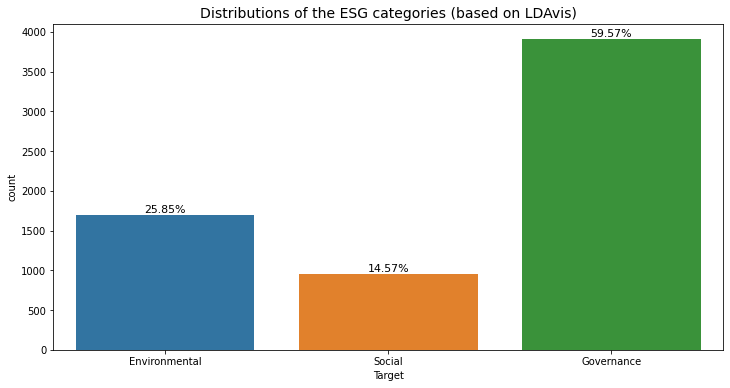

2    3908
0    1696
1     956
Name: ESG_category, dtype: int64


In [ ]:
df_dType = pd.DataFrame({'Target' : topic_vecs_df['ESG_category']})
total_counts = len(topic_vecs_df)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Target', data=df_dType)
ax.set_title('Distributions of the ESG categories (based on LDAvis)', fontsize=14)
for rectBox in ax.patches:
    count = rectBox.get_height()
    print("Counts :", count)
    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 30,  # Replace 50 (NIPS) for ESG offset at 0.3
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=11)

# Change the x-labels
plt.xticks(np.arange(3), ("Environmental", "Social", "Governance"))

plt.savefig('ESG_distributions_LDAvis', facecolor='w')
plt.show()

print(topic_vecs_df['ESG_category'].value_counts())

# Imbalance data for ESG papers

Note :
1. Tested with "lda_baselined_12_topics.model" with NIPS paper, 3-Means gives the same results as grouping via visual inspection
2. Automated Context Association based on L2-norm distance in "LDAvis_prepared.topic_coordinates"

In [ ]:
words_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,action,posterior,kernel,tree,object,cluster,word,loss,neuron,response,layer,target
1,policy,estimator,sparse,node,recognition,graph,item,classifier,dynamic,cell,gradient,motion
2,regret,latent,norm,memory,visual,edge,user,risk,activity,stimulus,architecture,source
3,reward,density,tensor,bit,convolutional,partition,topic,lemma,spike,visual,deep,dynamic
4,agent,mixture,column,path,segmentation,node,score,online,connection,filter,net,position
5,arm,variational,subspace,communication,detection,vertex,language,selection,circuit,brain,hide,move
6,reinforcement,likelihood,projection,prune,frame,submodular,document,active,simulation,spatial,activation,trajectory
7,game,sampling,regression,block,video,group,speech,hypothesis,fig,activity,recurrent,field
8,strategy,conditional,operator,hash,scene,graphical,sentence,margin,synaptic,frequency,hidden_unit,location
9,bandit,probabilistic,regularization,store,shape,clustering,text,metric,voltage,trial,connection,controller


## 3.2.1 Placing context with ESG categorical information
> * Learn from trained LDA model with K-Means clustering from LDAvis cluster coordinates
> * Group and save respective topic words into ESG categories which can be used to overcome cold-start (without ESG categorical information)
> * Use grouped ESG data words to build context in LDA generated topics

In [ ]:
# For ESG papers whereby there are only one cluster in a ESG category
topic_words_df = pd.DataFrame()
list_words = []
topic_id = 0
disp_words_topic = 30
disp_topics = optimal_num_topics

one_topic_words_prob = lda_baselined_model.show_topics(num_topics=disp_topics,
                                                       num_words=disp_words_topic, formatted=False)

# Retrieve top words from each topic for storing in data frame
for i in range(disp_words_topic):
    # print("Extracted word :", topics_words_prob[topic_idx][1][i][0])
    list_words.append(one_topic_words_prob[topic_id][1][i][0])

# Topicid (0-11) instead of the Topic number
topic_words_df['Topic_' + str(topic_id)] = list_words

# print(list_words)
# one_topic_words_prob
topic_words_df

In [ ]:
print("E_Topicids : {} with {} topics in category".format(E_Topicids, len(E_Topicids)))
print("S_Topicids : {} with {} topics in category".format(S_Topicids, len(S_Topicids)))
print("G_Topicids : {} with {} topics in category".format(G_Topicids, len(G_Topicids)))

min_topics_category = min(len(E_Topicids), len(S_Topicids), len(G_Topicids))
print("Min. topics in an ESG category based on K-Means :", min_topics_category)

E_Topicids : [9, 10, 8, 11] with 4 topics in category
S_Topicids : [4, 6] with 2 topics in category
G_Topicids : [1, 7, 2, 5, 0, 3] with 6 topics in category
Min. topics in an ESG category based on K-Means : 2


In [ ]:
words_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,action,posterior,kernel,tree,object,cluster,word,loss,neuron,response,layer,target
1,policy,estimator,sparse,node,recognition,graph,item,classifier,dynamic,cell,gradient,motion
2,regret,latent,norm,memory,visual,edge,user,risk,activity,stimulus,architecture,source
3,reward,density,tensor,bit,convolutional,partition,topic,lemma,spike,visual,deep,dynamic
4,agent,mixture,column,path,segmentation,node,score,online,connection,filter,net,position
5,arm,variational,subspace,communication,detection,vertex,language,selection,circuit,brain,hide,move
6,reinforcement,likelihood,projection,prune,frame,submodular,document,active,simulation,spatial,activation,trajectory
7,game,sampling,regression,block,video,group,speech,hypothesis,fig,activity,recurrent,field
8,strategy,conditional,operator,hash,scene,graphical,sentence,margin,synaptic,frequency,hidden_unit,location
9,bandit,probabilistic,regularization,store,shape,clustering,text,metric,voltage,trial,connection,controller


In [ ]:
topic_words_E = pd.DataFrame()
topic_words_S = pd.DataFrame()
topic_words_G = pd.DataFrame()

for i in range(min_topics_category):
    ESG_topicid = E_Topicids[i]
    # print("E_Topic index {} with Topicid : {} with words\n{}".format(i, ESG_topicid, words_df['Topic_'+str(ESG_topicid)]))
    # print()
    ESG_col_name = 'Topic_'+str(ESG_topicid)
    topic_words_E = topic_words_E.append(list(words_df[ESG_col_name].values), ignore_index=True)

    ESG_topicid = S_Topicids[i]
    # print("S_Topic index {} with Topicid : {} with words\n{}".format(i, ESG_topicid, words_df['Topic_'+str(ESG_topicids)]))
    # print()
    ESG_col_name = 'Topic_'+str(ESG_topicid)
    topic_words_S = topic_words_S.append(list(words_df[ESG_col_name].values), ignore_index=True)

    ESG_topicid = G_Topicids[i]
    # print("G_Topic index {} with Topicid : {} with words\n{}".format(i, ESG_topicid, words_df['Topic_'+str(ESG_topicids)]))
    ESG_col_name = 'Topic_'+str(ESG_topicid)
    topic_words_G = topic_words_G.append(list(words_df[ESG_col_name].values), ignore_index=True)

topic_words_E.columns = ['E_Topic_words']
topic_words_S.columns = ['S_Topic_words']
topic_words_G.columns = ['G_Topic_words']

display(topic_words_E)
display(topic_words_S)
display(topic_words_G)

# Sort words in ascending order
topic_words_E.sort_values(by='E_Topic_words', inplace=True, ignore_index=True)
topic_words_S.sort_values(by='S_Topic_words', inplace=True, ignore_index=True)
topic_words_G.sort_values(by='G_Topic_words', inplace=True, ignore_index=True)

# E_Topicids : [9, 10, 8, 11] with 4 topics in category
# S_Topicids : [4, 6] with 2 topics in category
# G_Topicids : [1, 7, 2, 5, 0, 3] with 6 topics in category
print("No. of topic words in 'Environment' category :", len(topic_words_E))
print("No. of topic words in 'Social' category :", len(topic_words_S))
print("No. of topic words in 'Governance' category :", len(topic_words_G))

# ESG_col_names = ['Environment', 'Social', 'Governance']

topic_words_ESG = pd.DataFrame({'Environment' : topic_words_E['E_Topic_words'],
                                'Social' : topic_words_S['S_Topic_words'],
                                'Governance' : topic_words_G['G_Topic_words']})

# topic_words_ESG.sort_values(by=['Environment'], ignore_index = True)
topic_words_ESG

,E_Topic_words
0,response
1,cell
2,stimulus
3,visual
4,filter
5,brain
6,spatial
7,activity
8,frequency
9,trial


,S_Topic_words
0,object
1,recognition
2,visual
3,convolutional
4,segmentation
5,detection
6,frame
7,video
8,scene
9,shape


,G_Topic_words
0,posterior
1,estimator
2,latent
3,density
4,mixture
5,variational
6,likelihood
7,sampling
8,conditional
9,probabilistic


No. of topic words in 'Environment' category : 20
No. of topic words in 'Social' category : 20
No. of topic words in 'Governance' category : 20


,Environment,Social,Governance
0,activation,convolutional,active
1,activity,detection,classifier
2,architecture,document,conditional
3,brain,frame,density
4,cell,item,estimator
5,connection,language,hypothesis
6,deep,object,latent
7,filter,recognition,lemma
8,frequency,scene,likelihood
9,gradient,score,loss


In [ ]:
# Save respective topic words from visual inspections via LDAvis into ESG categories (‘topics_ESG_words_data.csv')
# Store ESG words dataframe in CSV file for future consumption (overcome cold start, without ESG categorical information)
save_csv_file(topic_words_ESG, 'topics_ESG_words_data.csv')

## 3.2.2 Category inference on unseen document based on provided ESG Category words
> * Placing context with ESG categorical information, acquired from domain expertise with provided ESG word data file
> * This ESG word data file can be improved over time for improving context (based on knowledge or LDA model updates)

In [ ]:
# Load the updated ESG words for categorising the topics based on matching words ratio
topic_words_ESG = pd.read_csv('topics_ESG_words_data.csv') # /kaggle/input/nips-papers/

# Extract the words from the provided ESG words data file
popular_E_topic_words_list = topic_words_ESG['Environment']
popular_S_topic_words_list = topic_words_ESG['Social']
popular_G_topic_words_list = topic_words_ESG['Governance']

# Show the first 10 rows
topic_words_ESG

,Environment,Social,Governance
0,activation,convolutional,active
1,activity,detection,classifier
2,architecture,document,conditional
3,brain,frame,density
4,cell,item,estimator
5,connection,language,hypothesis
6,deep,object,latent
7,filter,recognition,lemma
8,frequency,scene,likelihood
9,gradient,score,loss


In [ ]:
# ** ESG : Simulate changes in word by domain expertise in the uploaded file 'topics_ESG_words_data.csv' file ** 
# pos = 11
# print("Sameple word from test_lemmatized :", test_lemmatized[0][0])
# print("original word at position {} of Social Category : {}".format(pos, topic_words_ESG['Social'][11]))
# topic_words_ESG['Social'][11] = test_lemmatized[0][0] # 'energy'
# print("Modified word at position {} of Social Category : {}".format(pos, topic_words_ESG['Social'][11]))

In [ ]:
# Match category based on list of words (top 30 words) from ESG document provided
def matching_doc_category(test_list_words: list, verbose: bool = False):    
    # Configure same number of words for each category
    num_topic_words = len(popular_E_topic_words_list)

    # Compare the top words from test document
    test_sample_top_words = test_list_words

    intersected_E_topic_words = intersection(test_sample_top_words, popular_E_topic_words_list)
    intersected_S_topic_words = intersection(test_sample_top_words, popular_S_topic_words_list)
    intersected_G_topic_words = intersection(test_sample_top_words, popular_G_topic_words_list)

    matching_E_topic_words_ratio = round(len(intersected_E_topic_words)/num_topic_words, 3)
    matching_S_topic_words_ratio = round(len(intersected_S_topic_words)/num_topic_words, 3)
    matching_G_topic_words_ratio = round(len(intersected_G_topic_words)/num_topic_words, 3)
    
    matching_topic_list = [('E', matching_E_topic_words_ratio),
                           ('S', matching_S_topic_words_ratio),
                           ('G', matching_G_topic_words_ratio)]

    # key is the argument for comparison, tuple item 1
    topic_category, max_ratio = max(matching_topic_list, key=lambda item: item[1])

    if verbose:
        print("{} intersected words in E category : {} having matching at {:.2f}%".format(len(intersected_E_topic_words), intersected_E_topic_words,
                                                                                          (matching_E_topic_words_ratio)*100))
        print("{} intersected words in S category : {} having matching at {:.2f}%".format(len(intersected_S_topic_words), intersected_S_topic_words,
                                                                                          (matching_S_topic_words_ratio)*100))
        print("{} intersected words in G category : {} having matching at {:.2f}%".format(len(intersected_G_topic_words), intersected_G_topic_words,
                                                                                          (matching_G_topic_words_ratio)*100))
        print()
        print("Top words from document with respective matching ratio in each category :\n", matching_topic_list)
        print()
        print("Document with highest ratio topic category :", topic_category)
        print()
    
    return topic_category, max_ratio

In [ ]:
# Show the first 30 words in the lemmatized words from the test sample document 
print(test_lemmatized[0][:30])

['malmo', 'challenge', 'lack', 'accurate', 'knowledge', 'environment', 'agent', 'uncertain', 'information', 'model', 'open', 'challenge', 'self', 'interested', 'agent', 'challenge', 'type', 'uncertainty', 'make', 'optimal', 'sequential', 'decision', 'complex', 'multiagent', 'lie', 'environment', 'relate', 'factor', 'system', 'agent']


In [ ]:
# Select the no. of words from sampled document for comparison, could be treated as a hyperparameter
# For example, all words in sampled document, the first element with max matching ratio will be selected for ties
# LDA_model inference is topicid=0 which is LDAvis_topic=9 in 'G' category
compare_word_idx = len(test_lemmatized[0])  # set at -200 will give category 'G'

test_list_words = test_lemmatized[0][:compare_word_idx] # replace :30 to all 1649 words in one "energy" paper
topic_category, max_ratio = matching_doc_category(test_list_words, verbose=True)  # ['memory', 'dynamic', 'parallel', 'distribute', 'bit']

print("Test document filename : '{}'".format(test_pdf_filename))
print("Inferred topic category is '{}', matching {} test words and based on maximum probability : {:.2f}%".format(topic_category, compare_word_idx, max_ratio*100))

4 intersected words in E category : ['deep', 'gradient', 'trial', 'response'] having matching at 20.00%
2 intersected words in S category : ['score', 'detection'] having matching at 10.00%
4 intersected words in G category : ['hypothesis', 'posterior', 'active', 'online'] having matching at 20.00%

Top words from document with respective matching ratio in each category :
 [('E', 0.2), ('S', 0.1), ('G', 0.2)]

Document with highest ratio topic category : E

Test document filename : 'HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf'
Inferred topic category is 'E', matching 2048 test words and based on maximum probability : 20.00%


In [ ]:
LDAvis_topic_coord

,x,y,topics,cluster,Freq,label
topic,,,,,,
1,0.088946,-0.012546,1,1,14.045445,G
7,0.171410,-0.032631,2,1,13.071139,G
2,0.132866,0.004428,3,1,11.100513,G
4,-0.105306,0.256404,4,1,7.975143,S
6,0.024683,0.192332,5,1,7.772515,S
9,-0.212686,0.040494,6,1,7.742632,E
5,0.134968,0.032759,7,1,7.640786,G
10,-0.039532,-0.047001,8,1,7.143269,E
0,0.089997,-0.133872,9,1,7.039652,G


## 3.3 Feature Engineering and Context Association

> Assumption : ESG words in each category from the provided ESG word data file (with input or modifications from domain expert)
> * LDA baselined model has been updated with the corpus from uploaded ESG word data file before generating the topic vector features
> * Depending on highest matching ratio to create the target values (E=0, S=1, G=2)
> * Label the documents with targets to be used for training and predictions
> * Observe the distribution plot of targets to be different from the plot created via LDA visual inspections.

In [ ]:
# Recap : Infer context of unseen test document with the uploaded ESG contextual words
test_list_words = test_lemmatized[0][:]  # Take all words from test paper instead of :30
topic_category, max_ratio = matching_doc_category(test_list_words)  # verbose=True to show more details

print("Test document filename : '{}'".format(test_pdf_filename))
print("Inferred topic category is '{}' with {} words and based on maximum matching ratio : {:.2f}%".format(topic_category, len(test_list_words), max_ratio*100))

Test document filename : 'HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf'
Inferred topic category is 'E' with 2048 words and based on maximum matching ratio : 20.00%


In [ ]:
top_n_words = 30
topicid = 0
lda_topics_words = lda_baselined_model.show_topic(topicid=topicid, topn=top_n_words)
total_words_prob = 0
counter = 0

for word, word_prob in lda_topics_words:
    counter += 1
    print("({}) '{}' in topicid_{} having word probability of {:.3f}%".format(counter, word, topicid, word_prob*100))
    total_words_prob += word_prob

print()
print("Top {} words in topicid_{} with accumulated word probability : {:.3f}%".format(top_n_words, topicid, total_words_prob*100))

(1) 'action' in topicid_0 having word probability of 4.332%
(2) 'policy' in topicid_0 having word probability of 4.271%
(3) 'regret' in topicid_0 having word probability of 3.174%
(4) 'reward' in topicid_0 having word probability of 2.643%
(5) 'agent' in topicid_0 having word probability of 2.267%
(6) 'arm' in topicid_0 having word probability of 1.697%
(7) 'reinforcement' in topicid_0 having word probability of 1.528%
(8) 'game' in topicid_0 having word probability of 1.293%
(9) 'strategy' in topicid_0 having word probability of 1.188%
(10) 'bandit' in topicid_0 having word probability of 1.141%
(11) 'decision' in topicid_0 having word probability of 1.055%
(12) 'player' in topicid_0 having word probability of 1.033%
(13) 'expert' in topicid_0 having word probability of 0.919%
(14) 'exploration' in topicid_0 having word probability of 0.829%
(15) 'environment' in topicid_0 having word probability of 0.724%
(16) 'round' in topicid_0 having word probability of 0.672%
(17) 'play' in topi

In [ ]:
lda_baselined_model.show_topic(topicid=topicid)

[('action', 0.043318875),
 ('policy', 0.04270559),
 ('regret', 0.03173837),
 ('reward', 0.026426854),
 ('agent', 0.022667132),
 ('arm', 0.016966661),
 ('reinforcement', 0.015278837),
 ('game', 0.012933364),
 ('strategy', 0.011881131),
 ('bandit', 0.01141177)]

In [ ]:
# Retrieve top words from topicid and store in list for comparison with the ESG words
def get_top_list_words(top_num_words: int, top_topic_words: list):
    list_words = []
    
    for i in range(top_num_words):
        # print("Extracted word_{} : {}".format(i, top_topic_words[i][0]))
        list_words.append(top_topic_words[i][0])
    return list_words

# Example : Get top 30 words for topicid, 0
topic_id = 0
top_num_words = 30

# This LDA model has not been updated with the unseen document at this point in time
top_topic_words = lda_baselined_model.show_topic(topicid=topic_id, topn=top_num_words)

# Show the top 30 words from topicid = 0
top_list_words = get_top_list_words(top_num_words, top_topic_words)
print("Top {} words in topicid : {}\n{}".format(top_num_words, topic_id, top_list_words))

Top 30 words in topicid : 0
['action', 'policy', 'regret', 'reward', 'agent', 'arm', 'reinforcement', 'game', 'strategy', 'bandit', 'decision', 'player', 'expert', 'exploration', 'environment', 'round', 'play', 'transition', 'utility', 'adaptive', 'return', 'feedback', 'online', 'skill', 'adversarial', 'budget', 'price', 'mdp', 'belief', 'learner']


In [ ]:
print("Uploaded Environment {} topic words :\n{}".format(len(popular_E_topic_words_list), popular_E_topic_words_list.tolist()))
print()
print("Uploaded Social {} topic words :\n{}".format(len(popular_S_topic_words_list), popular_S_topic_words_list.tolist()))
print()
print("Uploaded Governance {} topic words :\n{}".format(len(popular_G_topic_words_list), popular_G_topic_words_list.tolist()))

Uploaded Environment 20 topic words :
['activation', 'activity', 'architecture', 'brain', 'cell', 'connection', 'deep', 'filter', 'frequency', 'gradient', 'hidden_unit', 'hide', 'layer', 'net', 'recurrent', 'response', 'spatial', 'stimulus', 'trial', 'visual']

Uploaded Social 20 topic words :
['convolutional', 'detection', 'document', 'frame', 'item', 'language', 'object', 'recognition', 'scene', 'score', 'segmentation', 'sentence', 'shape', 'speech', 'text', 'topic', 'user', 'video', 'visual', 'word']

Uploaded Governance 20 topic words :
['active', 'classifier', 'conditional', 'density', 'estimator', 'hypothesis', 'latent', 'lemma', 'likelihood', 'loss', 'margin', 'metric', 'mixture', 'online', 'posterior', 'probabilistic', 'risk', 'sampling', 'selection', 'variational']


In [ ]:
# Using the uploaded context associated words to update previously trained LDA model
test_texts = [popular_E_topic_words_list.tolist(),
              popular_S_topic_words_list.tolist(),
              popular_G_topic_words_list.tolist()]

test_corpus = [train_id2word.doc2bow(text) for text in test_texts]

# Social 20 topic words
test_sample_doc = test_corpus[1]

# get vectors of the uploaded 30 'Social' context words
vector = lda_baselined_model[test_sample_doc]

# Observe the high probabilities for [(0, 0.31005925), (4, 0.34179917), (9, 0.3239473)] corresponding to topicid 0, 4 and 9 for 'Social' context
vector

([(4, 0.48547214), (6, 0.47484457)],
 [(103, [6]),
  (140, [4, 6]),
  (276, [4, 6]),
  (358, [6]),
  (377, [4]),
  (379, [4]),
  (388, [6]),
  (1005, [6]),
  (1008, [6, 4]),
  (1073, [4]),
  (1135, [4, 6]),
  (1170, [4]),
  (1742, [6]),
  (1903, [6, 4]),
  (2423, [6]),
  (2450, [6]),
  (2469, [6]),
  (2534, [4]),
  (3201, [4]),
  (4794, [4])],
 [(103, [(6, 0.99997556)]),
  (140, [(4, 0.8782923), (6, 0.12168834)]),
  (276, [(4, 0.92430335), (6, 0.07568582)]),
  (358, [(6, 0.9999835)]),
  (377, [(4, 0.9999774)]),
  (379, [(4, 0.99055684)]),
  (388, [(6, 0.99999356)]),
  (1005, [(6, 0.99997216)]),
  (1008, [(4, 0.027039353), (6, 0.97292906)]),
  (1073, [(4, 0.991243)]),
  (1135, [(4, 0.98188174), (6, 0.018113162)]),
  (1170, [(4, 0.9999761)]),
  (1742, [(6, 0.9999882)]),
  (1903, [(4, 0.32260558), (6, 0.6773785)]),
  (2423, [(6, 0.99997604)]),
  (2450, [(6, 0.99996966)]),
  (2469, [(6, 0.99998564)]),
  (2534, [(4, 0.9959702)]),
  (3201, [(4, 0.9999768)]),
  (4794, [(4, 0.9999846)])])

In [ ]:
# NIPS : topic_words_ESG['Social'] are using words from topicid 4 and 6 and matches the highest probability with 'get_document_topics'
LDAvis_topic_coord

,x,y,topics,cluster,Freq,label
topic,,,,,,
1,0.088946,-0.012546,1,1,14.045445,G
7,0.171410,-0.032631,2,1,13.071139,G
2,0.132866,0.004428,3,1,11.100513,G
4,-0.105306,0.256404,4,1,7.975143,S
6,0.024683,0.192332,5,1,7.772515,S
9,-0.212686,0.040494,6,1,7.742632,E
5,0.134968,0.032759,7,1,7.640786,G
10,-0.039532,-0.047001,8,1,7.143269,E
0,0.089997,-0.133872,9,1,7.039652,G


In [ ]:
# Get the topic distribution for the uploaded 30 'Social' context words, LDA inference with probabilities
# Observe high topic probabilities of test_texts[1] given below in (0, 0.31001878), (4, 0.34190816) and (9, 0.3238788)
# Topicid 0, 4 and 9 that maps exactly to the LDAVis Topic 7, 12 and 11 for 'Social' context
# if there is no change to the uploaded "topics_ESG_words_data.csv" file
top_topics = lda_baselined_model.get_document_topics(test_sample_doc, minimum_probability=0.0)
top_topics

[(0, 0.0039683273),
 (1, 0.0039683296),
 (2, 0.003968328),
 (3, 0.0039683264),
 (4, 0.4854805),
 (5, 0.0039683343),
 (6, 0.4748362),
 (7, 0.0039683306),
 (8, 0.0039683306),
 (9, 0.0039683473),
 (10, 0.003968333),
 (11, 0.0039683296)]

### Optional update LDA model :

In [ ]:
# Added to silent DeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Update the model by incrementally training on the new corpus from the uploaded ESG context file
    lda_baselined_model.update(test_corpus)

In [ ]:
%%time
train_vecs = []
max_prob_topic = []

# Matching with top 30 words in each topic; can be treated as a hyperparameter
top_num_words = 30

print("Creating vectors for {} samples based on updated LDA model with uploaded ESG word data...".format(len(papers_text_df)))
# For all papers
for i in range(len(papers_text_df)): # 6560
    top_topics = lda_baselined_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
    
    # Get the topic distribution for each paper's text from updated lda_baselined_model
    topic_vec = [top_topics[j][1] for j in range(optimal_num_topics)]
        
    # Save the topic with highest probability for each paper
    topic_id, max_prob= max(top_topics, key=lambda item: item[1])
    # print('Maximum probability:', max_prob, "with topic:", topic_id)
    max_prob_topic.append(topic_id)
    
    # Extend with another feature vector, total characters in each document
    topic_vec.extend([len(papers_text_df.iloc[i].paper_text)])
    
    # Create labels (0-2) based on assumptions that highest word ratio belonging to a provided ESG category words
    # Label the documents with targets to be used for training and predictions
    top_topic_words = lda_baselined_model.show_topic(topicid=topic_id, topn=top_num_words)
    top_list_words = get_top_list_words(top_num_words, top_topic_words) 
    topic_category, max_ratio = matching_doc_category(top_list_words)
    
    if (topic_category == 'E'):
        # 1 : Environmental
        topic_vec.extend([0])
    elif (topic_category == 'S'):
        # 2 : Social
        topic_vec.extend([1])
    else: # topic_category == 'G'
        # 3 : Governance
        topic_vec.extend([2])
    
    train_vecs.append(topic_vec)
    

# Get the train_vecs to be used as features (7 topic vectors based on probability and paper text length)
print("No. of {} samples with {} features".format(len(train_vecs), len(train_vecs[0])))
print()
print("First 5 samples of vector features:\n{} ".format(train_vecs[:5]))

Creating vectors for 6560 samples based on updated LDA model with uploaded ESG word data...
No. of 6560 samples with 14 features

First 5 samples of vector features:
[[0.014608685, 0.00011214515, 0.049723163, 0.1322299, 0.12258338, 0.00011214437, 0.10493909, 0.10843948, 0.08174284, 0.07474308, 0.0964239, 0.21434219, 21643, 0], [0.0032781833, 0.01741845, 0.00017682713, 0.0001768298, 0.0096949, 0.00017683681, 0.00017683161, 0.014144702, 0.45381334, 0.39152616, 0.100048155, 0.009368768, 15505, 0], [0.00012602146, 0.03392766, 0.000126019, 0.009804853, 0.00012601793, 0.00012601756, 0.00012601742, 0.011238203, 0.63933474, 0.29591417, 0.009024233, 0.00012601915, 20523, 0], [0.059219617, 0.3258887, 0.00019139748, 0.00019139904, 0.0001913952, 0.00019139543, 0.00019139618, 0.49158838, 0.0001913955, 0.030038066, 0.091925465, 0.00019139882, 19441, 2], [0.00021859424, 0.073479, 0.011724602, 0.00021859145, 0.008392195, 0.00021859258, 0.00021859653, 0.72709084, 0.00021860455, 0.04338557, 0.09965018, 

In [ ]:
print("There are {} documents and the first 10 samples having topics with max prob :\n{}".format(len(max_prob_topic),
                                                                                                 max_prob_topic[:10]))

There are 6560 documents and the first 10 samples having topics with max prob :
[11, 8, 8, 7, 7, 10, 8, 8, 8, 8]


In [ ]:
# Create dataframe for topic vectors, total_chars and ESG_category
topic_vecs_df = pd.DataFrame(train_vecs, columns=col_names)
topic_vecs_df[:10]

,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars,ESG_category
0,0.014609,0.000112,0.049723,0.132230,0.122583,0.000112,0.104939,0.108439,0.081743,0.074743,0.096424,0.214342,21643,0
1,0.003278,0.017418,0.000177,0.000177,0.009695,0.000177,0.000177,0.014145,0.453813,0.391526,0.100048,0.009369,15505,0
2,0.000126,0.033928,0.000126,0.009805,0.000126,0.000126,0.000126,0.011238,0.639335,0.295914,0.009024,0.000126,20523,0
3,0.059220,0.325889,0.000191,0.000191,0.000191,0.000191,0.000191,0.491588,0.000191,0.030038,0.091925,0.000191,19441,2
4,0.000219,0.073479,0.011725,0.000219,0.008392,0.000219,0.000219,0.727091,0.000219,0.043386,0.099650,0.035185,20219,2
5,0.000155,0.149010,0.012846,0.027453,0.358294,0.000155,0.041418,0.009477,0.000155,0.019846,0.364000,0.017190,22451,0
6,0.000238,0.139680,0.034620,0.082604,0.000238,0.040631,0.008698,0.015258,0.263012,0.165564,0.249218,0.000238,13053,0
7,0.000165,0.033977,0.000165,0.009965,0.021022,0.000165,0.000165,0.092110,0.471120,0.114400,0.153685,0.103061,17870,0
8,0.000169,0.053232,0.000169,0.005842,0.224577,0.028737,0.000169,0.017267,0.301720,0.004739,0.176059,0.187321,17312,0
9,0.000088,0.035432,0.000088,0.042876,0.098375,0.023224,0.000088,0.003599,0.557594,0.002064,0.090715,0.145858,31503,0


Counts : 2669
Counts : 1405
Counts : 2486


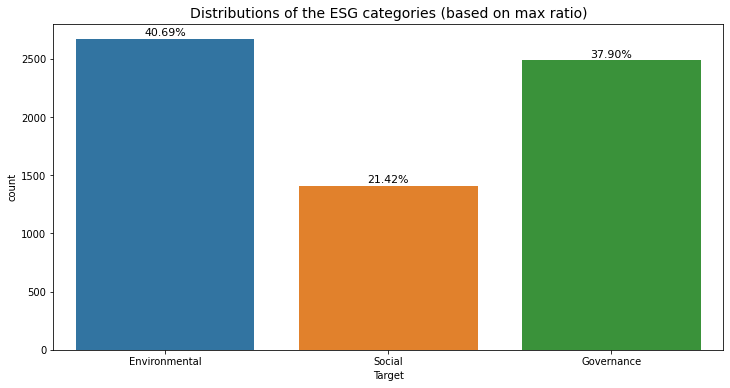

0    2669
2    2486
1    1405
Name: ESG_category, dtype: int64


In [ ]:
df_dType = pd.DataFrame({'Target' : topic_vecs_df['ESG_category']})
total_counts = len(topic_vecs_df)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Target', data=df_dType)
ax.set_title('Distributions of the ESG categories (based on max ratio)', fontsize=14)
for rectBox in ax.patches:
    count = rectBox.get_height()
    print("Counts :", count)
    
    ax.text(rectBox.get_x() + rectBox.get_width()/2.,
            count + 30,  # Replace 50 (NIPS) for ESG offset at 0.3
            '{:1.2f}%'.format(count/total_counts*100),
            ha="center", fontsize=11)

# Change the x-labels
plt.xticks(np.arange(3), ("Environmental", "Social", "Governance"))

plt.savefig('ESG_distributions_max_ratio', facecolor='w')
plt.show()

print(topic_vecs_df['ESG_category'].value_counts())

## 4. Multi-class Classifications

In [ ]:
X = topic_vecs_df.drop(columns=['ESG_category'], axis=1)
y = topic_vecs_df['ESG_category']
X.shape, y.shape

((6560, 13), (6560,))

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score
# pd.options.display_max_colums = 999

# Standardize features by removing the mean and scaling to unit variance does not have any difference
# std_scaler = StandardScaler()
# std_scaler.fit(X)
# X_scaled = pd.DataFrame(std_scaler.fit_transform(X))

# Train-Test-Split (0.7, 03)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # X_scaled

# Converting the dataset into LightGBM format
lgb_dataset = lgb.Dataset(X_train, label=y_train)
X_train

,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars
6399,0.000146,0.029837,0.007947,0.028059,0.012737,0.000146,0.001369,0.056131,0.735788,0.098153,0.029541,0.000146,18966
5623,0.019104,0.073714,0.008922,0.132345,0.017700,0.600632,0.000075,0.147208,0.000075,0.000075,0.000075,0.000075,39820
5141,0.071694,0.287078,0.011786,0.031746,0.002359,0.042351,0.264464,0.036112,0.019078,0.046705,0.144394,0.042233,37581
6505,0.024684,0.019589,0.000124,0.000124,0.194296,0.000124,0.000124,0.000124,0.072342,0.369540,0.000124,0.318806,21404
4952,0.074591,0.777693,0.023395,0.014989,0.022083,0.029643,0.005085,0.030624,0.000116,0.000116,0.010095,0.011569,30527
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.847421,0.000114,0.008004,0.027999,0.005362,0.000114,0.009127,0.085774,0.000114,0.015742,0.000114,0.000114,32650
5191,0.000140,0.034569,0.000140,0.000140,0.234689,0.018252,0.075397,0.000140,0.048363,0.000140,0.502650,0.085381,20124
5226,0.010580,0.000107,0.142375,0.214411,0.006270,0.014153,0.005464,0.572183,0.000107,0.000107,0.022472,0.011771,36551
5390,0.000187,0.005047,0.131396,0.007428,0.000187,0.018967,0.046540,0.000187,0.449404,0.000187,0.263149,0.077321,15469


In [ ]:
lgb_params = {}
lgb_params['learning_rate']=0.03
lgb_params['boosting_type']='gbdt'      # Gradient Boosting Decision Tree as the base algorithm
lgb_params['objective'] = 'multiclass'  # Multi-class target
lgb_params['metric'] = 'multi_logloss'  # Metric for Multi-class Classification
lgb_params['max_depth'] = 10            # Max. depth for decision tree
lgb_params['num_class'] = 3             # No. of class
lgb_params

{'boosting_type': 'gbdt',
 'learning_rate': 0.03,
 'max_depth': 10,
 'metric': 'multi_logloss',
 'num_class': 3,
 'objective': 'multiclass'}

In [ ]:
%%time
epochs = 100
lgbm_clf = lgb.train(lgb_params, lgb_dataset, epochs)
lgbm_clf

CPU times: user 1.59 s, sys: 59.4 ms, total: 1.65 s
Wall time: 877 ms


In [ ]:
# Prediction on the test set from topic_vecs_df (contains all documents topic vectors and other features)
y_pred = lgbm_clf.predict(X_test)
y_pred.shape

(1968, 3)

In [ ]:
# Using no.argmax() to show the most probable ESG context (Envirnomental = 0, Social = 1 and Goverance = 2)
y_pred = [np.argmax(pred) for pred in y_pred]
y_pred[:10]

[0, 0, 0, 1, 0, 1, 0, 0, 1, 2]

In [ ]:
# Precision Score
precision_score(y_pred, y_test, average=None).mean()

# Precision Score low as there are too little data and Environment category has more than 80%
# dataset imbalance due to too little matched words (0nly 30 words selected from ESG uploaded file)

0.9615963001609745

## Predictions of context for unseen document 
> 1. Extract texts of an unseen document to datafrmae
> 2. Use the LDA model to generate topic vectors and other features (no. of characters in text)
> 3. Verify context predictions with trained LGBM model against inferred topic category based on maximum matching ratio

In [ ]:
test_pdf_filename

'HogRider_Champion Agent of Microsoft Malmo Collaborative AI Challenge.pdf'

In [ ]:
# test_lemmatized from the unseen test document
test_corpus = [train_id2word.doc2bow(text) for text in test_lemmatized]
# There is only one unseen document for LDA inference
len(test_corpus), len(test_corpus[0])

(1, 327)

In [ ]:
test_top_topics = lda_baselined_model.get_document_topics(test_corpus[0], minimum_probability=0.0)
test_top_topics

[(0, 0.65861416),
 (1, 0.038250696),
 (2, 9.473455e-05),
 (3, 0.02016186),
 (4, 0.061955348),
 (5, 0.011203278),
 (6, 0.021144854),
 (7, 0.07092739),
 (8, 0.005301983),
 (9, 9.473393e-05),
 (10, 0.017127227),
 (11, 0.09512375)]

In [ ]:
# Get the topic distribution for each paper's text from updated lda_baselined_model
test_topic_vec = [test_top_topics[j][1] for j in range(optimal_num_topics)]
test_topic_vec.extend([test_text_df['chars'][1]])  # pdf_text_df
test_topic_vec

[0.65861416,
 0.038250696,
 9.473455e-05,
 0.02016186,
 0.061955348,
 0.011203278,
 0.021144854,
 0.07092739,
 0.005301983,
 9.473393e-05,
 0.017127227,
 0.09512375,
 31350]

In [ ]:
test_col_names = col_names.copy()
test_col_names.remove('ESG_category')
[test_col_names], [col_names]

([['topic_vec_0',
   'topic_vec_1',
   'topic_vec_2',
   'topic_vec_3',
   'topic_vec_4',
   'topic_vec_5',
   'topic_vec_6',
   'topic_vec_7',
   'topic_vec_8',
   'topic_vec_9',
   'topic_vec_10',
   'topic_vec_11',
   'total_chars']],
 [['topic_vec_0',
   'topic_vec_1',
   'topic_vec_2',
   'topic_vec_3',
   'topic_vec_4',
   'topic_vec_5',
   'topic_vec_6',
   'topic_vec_7',
   'topic_vec_8',
   'topic_vec_9',
   'topic_vec_10',
   'topic_vec_11',
   'total_chars',
   'ESG_category']])

In [ ]:
test_topic_vecs_df = pd.DataFrame([test_topic_vec], columns=test_col_names)
test_topic_vecs_df

,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars
0,0.658614,0.038251,0.000095,0.020162,0.061955,0.011203,0.021145,0.070927,0.005302,0.000095,0.017127,0.095124,31350


In [ ]:
X_test = test_topic_vecs_df
y_pred = lgbm_clf.predict(X_test)
y_pred

array([[0.02309876, 0.01333095, 0.9635703 ]])

In [ ]:
# Get the highest value index
np.argmax(y_pred) # which is G = 2 for NIPS with topicid_0 (LDAvis_topic = 9) prediction from LDA model
# For ESG : supposed to be 'S' (=1) for unseen 'energy' paper

2

In [ ]:
LDAvis_topic_coord

,x,y,topics,cluster,Freq,label
topic,,,,,,
1,0.088946,-0.012546,1,1,14.045445,G
7,0.171410,-0.032631,2,1,13.071139,G
2,0.132866,0.004428,3,1,11.100513,G
4,-0.105306,0.256404,4,1,7.975143,S
6,0.024683,0.192332,5,1,7.772515,S
9,-0.212686,0.040494,6,1,7.742632,E
5,0.134968,0.032759,7,1,7.640786,G
10,-0.039532,-0.047001,8,1,7.143269,E
0,0.089997,-0.133872,9,1,7.039652,G


#### For the above verifications, the prediction is similar to the inferred category based on maximum matching ratio
> * This makes sense as we did not change the words in the ESG word data file, 'topics_ESG_words_data.csv'

In [ ]:
papers_text_pred_df = pd.concat([papers_text_df, topic_vecs_df], axis=1)

# stack the columns in the second DataFrame to the RIGHT of the first DataFrame
papers_text_pred_df

,year,title,pdf_name,paper_text,topic_vec_0,topic_vec_1,topic_vec_2,topic_vec_3,topic_vec_4,topic_vec_5,topic_vec_6,topic_vec_7,topic_vec_8,topic_vec_9,topic_vec_10,topic_vec_11,total_chars,ESG_category
0,1987,Self-Organization of Associative Database and ...,1-self-organization-of-associative-database-an...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,0.014609,0.000112,0.049723,0.132230,0.122583,0.000112,0.104939,0.108439,0.081743,0.074743,0.096424,0.214342,21643,0
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,10-a-mean-field-theory-of-layer-iv-of-visual-c...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,0.003278,0.017418,0.000177,0.000177,0.009695,0.000177,0.000177,0.014145,0.453813,0.391526,0.100048,0.009369,15505,0
2,1988,Storing Covariance by the Associative Long-Ter...,100-storing-covariance-by-the-associative-long...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,0.000126,0.033928,0.000126,0.009805,0.000126,0.000126,0.000126,0.011238,0.639335,0.295914,0.009024,0.000126,20523,0
3,1994,Bayesian Query Construction for Neural Network...,1000-bayesian-query-construction-for-neural-ne...,Bayesian Query Construction for Neural\nNetwor...,0.059220,0.325889,0.000191,0.000191,0.000191,0.000191,0.000191,0.491588,0.000191,0.030038,0.091925,0.000191,19441,2
4,1994,"Neural Network Ensembles, Cross Validation, an...",1001-neural-network-ensembles-cross-validation...,"Neural Network Ensembles, Cross\nValidation, a...",0.000219,0.073479,0.011725,0.000219,0.008392,0.000219,0.000219,0.727091,0.000219,0.043386,0.099650,0.035185,20219,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6555,1994,Single Transistor Learning Synapses,994-single-transistor-learning-synapses.pdf,Single Transistor Learning Synapses\n\nPaul Ha...,0.000140,0.000140,0.000140,0.000140,0.000140,0.011819,0.000140,0.000140,0.862368,0.024242,0.022392,0.078198,18345,0
6556,1994,"Bias, Variance and the Combination of Least Sq...",996-bias-variance-and-the-combination-of-least...,"Bias, Variance and the Combination of\nLeast S...",0.000167,0.664654,0.088628,0.000167,0.000167,0.000167,0.000167,0.135829,0.002857,0.000167,0.106864,0.000167,22944,2
6557,1994,A Real Time Clustering CMOS Neural Engine,997-a-real-time-clustering-cmos-neural-engine.pdf,A Real Time Clustering CMOS\nNeural Engine\nT....,0.000224,0.000224,0.000224,0.080108,0.067923,0.041210,0.000224,0.000224,0.580739,0.003642,0.117214,0.108044,14731,0
6558,1994,Learning direction in global motion: two class...,998-learning-direction-in-global-motion-two-cl...,Learning direction in global motion: two\nclas...,0.000135,0.000135,0.000135,0.000135,0.048393,0.057658,0.000135,0.000135,0.055962,0.553899,0.020678,0.262601,20421,0


In [ ]:
papers_text_df.shape, topic_vecs_df.shape, papers_text_pred_df.shape

((6560, 4), (6560, 14), (6560, 18))

In [ ]:
# 3 main categories with can be mapped to "Environmental", "Social" and "Governance"
# Create file for predictions
def create_file_for_predictions(filename, pdf_name, predictions):    
    predictions_df = pd.DataFrame({'pdf_name': pdf_name, 'target': predictions})
    predictions_df.to_csv(filename, index=False)

In [ ]:
# papers_text_df.columns, topic_vecs_df.columns start @ 16:43
create_file_for_predictions('pdf_name_ESG.csv', papers_text_pred_df['pdf_name'],
                            papers_text_pred_df['ESG_category'])

## End of Program

## Helper functions

In [ ]:
# a_string = '!hi. wh?at is the weat[h]er lik?e.'
# new_string = re.sub(r'[\[,\\.!?\]]', '', a_string) # [^\w\s] except words and spaces
# new_string

In [ ]:
# Remove the mapped LDAvis Topics from words_df and do not need to remove the 3 unwanted rows
# topic_words_ESG = topic_words_ESG.drop(labels=[0,1,2], axis=0).reset_index()
# topic_words_ESG.drop("index", axis=1, inplace=True)
# topic_words_ESG